In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
import tensorflow as tf
import pytorch_lightning as pl
from torch import nn
import statistics

In [2]:
res = pd.read_csv('../multi_model_multi_metric_results_50samples.csv')

In [13]:
sorted_res = res.sort_values('average_res', ascending=False)
sorted_res = sorted_res.reset_index(drop=True)

In [14]:
sorted_res

,trial_id,pt_test_acc,tf_test_acc,pt_uniform_accuracy,tf_uniform_accuracy,pt_gaussian_accuracy,tf_gaussian_accuracy,pt_saltandpepper_accuracy,tf_saltandpepper_accuracy,average_res,...,hostname,node_ip,time_since_restore,timesteps_since_restore,iterations_since_restore,experiment_tag,config.learning_rate,config.dropout,config.epochs,config.batch_size
0,0e5929d2,0.998197,0.9811,0.994332,1.000000,0.994939,1.000000,0.996761,0.998785,0.995514,...,iotagpu02,140.221.68.6,256.607727,0,1,"14_batch_size=380,dropout=0.24657,epochs=48,le...",0.000825,0.246572,48,380
1,9151e550,0.996826,0.9795,0.993781,1.000000,0.992248,1.000000,0.993100,1.000000,0.994432,...,iotagpu02,140.221.68.6,320.464005,0,1,"35_batch_size=903,dropout=0.27537,epochs=66,le...",0.012401,0.275365,66,903
2,76371a10,0.998608,0.9805,0.989321,1.000000,0.989502,1.000000,0.988959,1.000000,0.993361,...,iotagpu02,140.221.68.6,324.775977,0,1,"3_batch_size=425,dropout=0.20528,epochs=63,lea...",0.006298,0.205277,63,425
3,7638fede,0.996219,0.9772,0.989762,1.000000,0.990684,1.000000,0.989116,1.000000,0.992873,...,iotagpu02,140.221.68.6,273.535355,0,1,"13_batch_size=834,dropout=0.33713,epochs=54,le...",0.011433,0.337133,54,834
4,91524496,0.997467,0.9791,0.987692,0.999919,0.987692,1.000000,0.987206,0.995628,0.991838,...,iotagpu02,140.221.68.6,304.021725,0,1,"37_batch_size=950,dropout=0.39859,epochs=64,le...",0.008333,0.398595,64,950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,d11cb46e,0.106483,0.1028,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.101160,...,iotagpu02,140.221.68.6,747.886587,0,1,"10_batch_size=60,dropout=0.84696,epochs=95,lea...",0.088616,0.846961,95,60
796,de73a89c,0.098633,0.0980,0.050000,0.150000,0.050000,0.150000,0.050000,0.150000,0.099579,...,iotagpu02,140.221.68.6,320.834164,0,1,"42_batch_size=100,dropout=0.89965,epochs=49,le...",0.082187,0.899646,49,100
797,44b37ac4,0.150513,0.1028,0.061966,0.097222,0.067308,0.097222,0.070513,0.097222,0.093096,...,iotagpu02,140.221.68.6,352.766173,0,1,"28_batch_size=72,dropout=0.84538,epochs=47,lea...",0.060203,0.845378,47,72
798,807946ca,0.115931,0.1321,0.100993,0.051325,0.100993,0.051325,0.100993,0.051325,0.088123,...,iotagpu02,140.221.68.6,415.407106,0,1,"14_batch_size=604,dropout=0.89302,epochs=85,le...",0.086946,0.893016,85,604


In [29]:
class NumberNet(pl.LightningModule):
    def __init__(self, config):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Dropout(config['dropout']),
            nn.Linear(128, 10))
            ## nn.Softmax())
            # not include softmax because it's included in the Cross Entropy Loss Function
        self.criterion = nn.CrossEntropyLoss()
        self.config = config
        self.test_loss = None
        self.test_accuracy = None
        self.accuracy = pl.metrics.Accuracy()

    def train_dataloader(self):
        return torch.utils.data.DataLoader(torchvision.datasets.MNIST("~/resiliency/", train=True,
                                                                      transform=torchvision.transforms.ToTensor(),
                                                                      target_transform=None, download=True),
                                           batch_size=int(self.config['batch_size']))

    def test_dataloader(self):
        return torch.utils.data.DataLoader(torchvision.datasets.MNIST("~/resiliency/", train=True,
                                                                      transform=torchvision.transforms.ToTensor(),
                                                                      target_transform=None, download=True),
                                           batch_size=int(self.config['batch_size']))

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.config['learning_rate'])
        return optimizer

    def forward(self, x):
        return self.model(x)

    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        logits = self.forward(x)
        loss = self.criterion(logits, y)
        logs = {'train_loss': loss}
        return {'loss': loss}

    def test_step(self, test_batch, batch_idx):
        x, y = test_batch
        logits = self.forward(x)
        loss = self.criterion(logits, y)
        accuracy = self.accuracy(logits, y)
        logs = {'test_loss': loss, 'test_accuracy': accuracy}
        return {'test_loss': loss, 'logs': logs, 'test_accuracy': accuracy}

    def test_epoch_end(self, outputs):
        loss = []
        for x in outputs:
            loss.append(float(x['test_loss']))
        avg_loss = statistics.mean(loss)
        tensorboard_logs = {'test_loss': avg_loss}
        self.test_loss = avg_loss
        accuracy = []
        for x in outputs:
            accuracy.append(float(x['test_accuracy']))
        avg_accuracy = statistics.mean(accuracy)
        self.test_accuracy = avg_accuracy
        return {'avg_test_loss': avg_loss, 'log': tensorboard_logs, 'avg_test_accuracy': avg_accuracy}

def mnist_pt_objective(config):
    model = NumberNet(config)
    trainer = pl.Trainer(max_epochs=config['epochs'])
    trainer.fit(model)
    trainer.test(model)
    return (model.test_accuracy, model)


def mnist_tf_objective(config):
    mnist = tf.keras.datasets.mnist

    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train, x_test = x_train / 255.0, x_test / 255.0

    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(config['dropout']),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

    opt = tf.keras.optimizers.Adam(learning_rate=config['learning_rate'])

    model.compile(optimizer=opt,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    res = model.fit(x_train, y_train, epochs=config['epochs'], batch_size=config['batch_size'])
    res_test = model.evaluate(x_test, y_test)
    return (res_test[1], model)

In [24]:
top = sorted_res.iloc[0]
top_config = {'learning_rate':top['config.learning_rate'], 'batch_size':top['config.batch_size'], 'dropout':top['config.dropout'], 'epochs':top['config.epochs']}

In [25]:
bottom = sorted_res.iloc[-1]
bottom_config = {'learning_rate':bottom['config.learning_rate'], 'batch_size':bottom['config.batch_size'], 'dropout':bottom['config.dropout'], 'epochs':bottom['config.epochs']}

In [32]:
top_pt_accuracy, top_pt_model = mnist_pt_objective(top_config)
top_tf_accuracy, top_tf_model = mnist_tf_objective(top_config)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Sequential       | 101 K 
1 | criterion | CrossEntropyLoss | 0     
2 | accuracy  | Accuracy         | 0     


Epoch 47: 100%|██████████| 158/158 [00:05<00:00, 28.79it/s, loss=0.026, v_num=43]

Saving latest checkpoint..


Testing:  98%|█████████▊| 155/158 [00:04<00:00, 34.72it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_accuracy': 0.9981159760227686,
 'avg_test_loss': 0.00993318008030529,
 'test_loss': 0.00993318008030529}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 158/158 [00:04<00:00, 33.89it/s]
Epoch 1/48
158/158 [==============================] - 0s 3ms/step - loss: 0.6238 - accuracy: 0.8242
Epoch 2/48
158/158 [==============================] - 0s 3ms/step - loss: 0.2907 - accuracy: 0.9178
Epoch 3/48
158/158 [==============================] - 0s 3ms/step - loss: 0.2310 - accuracy: 0.9336
Epoch 4/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1952 - accuracy: 0.9445
Epoch 5/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1703 - accuracy: 0.9509
Epoch 6/48
158/158 [==============================] - 0s 3ms/step - loss: 0.150

In [33]:
bottom_pt_accuracy, bottom_pt_model = mnist_pt_objective(bottom_config)
bottom_tf_accuracy, bottom_tf_model = mnist_tf_objective(bottom_config)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Sequential       | 101 K 
1 | criterion | CrossEntropyLoss | 0     
2 | accuracy  | Accuracy         | 0     


Epoch 67: 100%|██████████| 896/896 [00:10<00:00, 82.32it/s, loss=2.307, v_num=44]

Saving latest checkpoint..


Testing: 100%|█████████▉| 894/896 [00:05<00:00, 155.95it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_accuracy': 0.0986721418781339,
 'avg_test_loss': 2.3037801698914597,
 'test_loss': 2.3037801698914597}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 896/896 [00:05<00:00, 159.51it/s]
Epoch 1/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3776 - accuracy: 0.1094
Epoch 2/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3100 - accuracy: 0.1021
Epoch 3/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3098 - accuracy: 0.1024
Epoch 4/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3098 - accuracy: 0.1050
Epoch 5/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3101 - accuracy: 0.1015: 0s - loss: 2.3105 - accuracy: 0.
Epoch 6/68
896/896 [=========================

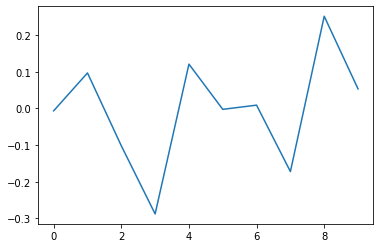

In [75]:
plt.plot(list(range(10)), list(top_pt_model.parameters())[-1].detach().numpy())

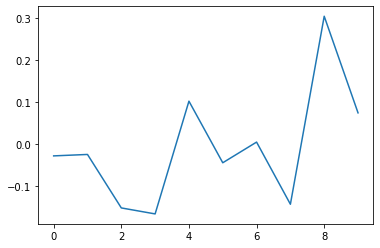

In [78]:
plt.plot(list(range(10)), top_tf_model.weights[-1].numpy())

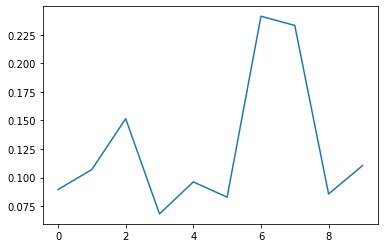

In [79]:
plt.plot(list(range(10)), list(bottom_pt_model.parameters())[-1].detach().numpy())

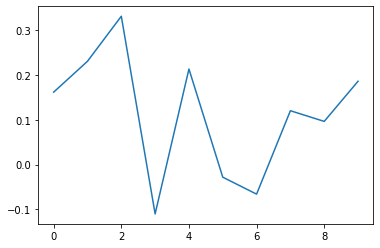

In [80]:
plt.plot(list(range(10)), bottom_tf_model.weights[-1].numpy())

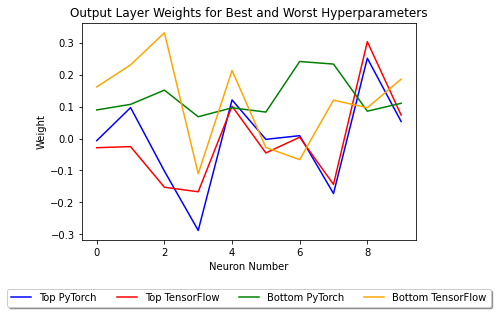

In [83]:
ax = plt.gca()
ax.plot(list(range(10)), list(top_pt_model.parameters())[-1].detach().numpy(), color="blue", label="Top PyTorch")
ax.plot(list(range(10)), top_tf_model.weights[-1].numpy(), color="red", label="Top TensorFlow")
ax.plot(list(range(10)), list(bottom_pt_model.parameters())[-1].detach().numpy(), color="green", label="Bottom PyTorch")
ax.plot(list(range(10)), bottom_tf_model.weights[-1].numpy(), color="orange", label="Bottom TensorFlow")
ax.set_title("Output Layer Weights for Best and Worst Hyperparameters")
ax.set_xlabel("Neuron Number")
ax.set_ylabel("Weight")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20),
          fancybox=True, shadow=True, ncol=5)
plt.show()

In [85]:
### Repeat experiment with multiple trials, get output weights

In [ ]:
top_pt, top_tf, bottom_pt, bottom_tf = [], [], [], []
for i in range(50):
    top_pt_accuracy, top_pt_model = mnist_pt_objective(top_config)
    top_tf_accuracy, top_tf_model = mnist_tf_objective(top_config)
    bottom_pt_accuracy, bottom_pt_model = mnist_pt_objective(bottom_config)
    bottom_tf_accuracy, bottom_tf_model = mnist_tf_objective(bottom_config)
    # get the output layer weights
    top_pt_out = list(top_pt_model.parameters())[-1].detach().numpy()
    top_pt.append(top_pt_out)
    top_tf_out = top_tf_model.weights[-1].numpy()
    top_tf.append(top_tf_out)
    bottom_pt_out = list(bottom_pt_model.parameters())[-1].detach().numpy()
    bottom_pt.append(bottom_pt_out)
    bottom_tf_out = bottom_tf_model.weights[-1].numpy()
    bottom_tf.append(bottom_tf_out)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
/Users/mzvyagin/miniconda3/envs/resiliency/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: Could not log computational graph since the `model.example_input_array` attribute is not set or `input_array` was not given
  warnings.warn(*args, **kwargs)

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Sequential       | 101 K 
1 | criterion | CrossEntropyLoss | 0     
2 | accuracy  | Accuracy         | 0     


Epoch 0:   1%|          | 1/158 [00:00<00:19,  8.09it/s, loss=2.308, v_num=45]

/Users/mzvyagin/miniconda3/envs/resiliency/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Epoch 47: 100%|██████████| 158/158 [00:05<00:00, 28.66it/s, loss=0.024, v_num=45]

Saving latest checkpoint..


Testing:   3%|▎         | 4/158 [00:00<00:05, 30.68it/s]

/Users/mzvyagin/miniconda3/envs/resiliency/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Testing:  99%|█████████▊| 156/158 [00:04<00:00, 33.27it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_accuracy': 0.9982639147511011,
 'avg_test_loss': 0.009682192919183452,
 'test_loss': 0.009682192919183452}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 158/158 [00:04<00:00, 33.75it/s]
Epoch 1/48
158/158 [==============================] - 0s 3ms/step - loss: 0.6306 - accuracy: 0.8209
Epoch 2/48
158/158 [==============================] - 0s 3ms/step - loss: 0.2860 - accuracy: 0.9189
Epoch 3/48
158/158 [==============================] - 0s 3ms/step - loss: 0.2258 - accuracy: 0.9353
Epoch 4/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1923 - accuracy: 0.9445
Epoch 5/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1660 - accuracy: 0.9529
Epoch 6/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Sequential       | 101 K 
1 | criterion | CrossEntropyLoss | 0     
2 | accuracy  | Accuracy         | 0     


Epoch 67: 100%|██████████| 896/896 [00:09<00:00, 92.77it/s, loss=2.307, v_num=46] 

Saving latest checkpoint..


Testing:  99%|█████████▉| 887/896 [00:05<00:00, 150.35it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_accuracy': 0.0986721418781339,
 'avg_test_loss': 2.303780241470252,
 'test_loss': 2.303780241470252}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 896/896 [00:05<00:00, 162.59it/s]
Epoch 1/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3784 - accuracy: 0.1105
Epoch 2/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3365 - accuracy: 0.1053
Epoch 3/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3149 - accuracy: 0.1032
Epoch 4/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3152 - accuracy: 0.1049
Epoch 5/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3089 - accuracy: 0.1034: 0s - loss: 2.3090 - ac
Epoch 6/68
896/896 [==============================] - 1s 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Sequential       | 101 K 
1 | criterion | CrossEntropyLoss | 0     
2 | accuracy  | Accuracy         | 0     


Epoch 47: 100%|██████████| 158/158 [00:05<00:00, 29.61it/s, loss=0.022, v_num=47]

Saving latest checkpoint..


Testing:  99%|█████████▊| 156/158 [00:04<00:00, 32.85it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_accuracy': 0.9982972262026388,
 'avg_test_loss': 0.009009978434076839,
 'test_loss': 0.009009978434076839}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 158/158 [00:04<00:00, 32.58it/s]
Epoch 1/48
158/158 [==============================] - 0s 2ms/step - loss: 0.6200 - accuracy: 0.8238
Epoch 2/48
158/158 [==============================] - 0s 3ms/step - loss: 0.2846 - accuracy: 0.9190
Epoch 3/48
158/158 [==============================] - 0s 2ms/step - loss: 0.2225 - accuracy: 0.9365
Epoch 4/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1887 - accuracy: 0.9462
Epoch 5/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1638 - accuracy: 0.9528
Epoch 6/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Sequential       | 101 K 
1 | criterion | CrossEntropyLoss | 0     
2 | accuracy  | Accuracy         | 0     


Epoch 67: 100%|██████████| 896/896 [00:09<00:00, 93.68it/s, loss=2.307, v_num=48]

Saving latest checkpoint..


Testing:  99%|█████████▊| 884/896 [00:05<00:00, 161.31it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_accuracy': 0.09870545744862673,
 'avg_test_loss': 2.3037461502743617,
 'test_loss': 2.3037461502743617}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 896/896 [00:05<00:00, 168.13it/s]
Epoch 1/68
896/896 [==============================] - 1s 1ms/step - loss: 2.4013 - accuracy: 0.1062
Epoch 2/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3134 - accuracy: 0.1024: 0s - l
Epoch 3/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3098 - accuracy: 0.1041
Epoch 4/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3102 - accuracy: 0.1026
Epoch 5/68
896/896 [==============================] - 1s 2ms/step - loss: 2.3112 - accuracy: 0.1019
Epoch 6/68
896/896 [==============================] - 1s 1ms/step - lo

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Sequential       | 101 K 
1 | criterion | CrossEntropyLoss | 0     
2 | accuracy  | Accuracy         | 0     


Epoch 47: 100%|██████████| 158/158 [00:05<00:00, 29.37it/s, loss=0.024, v_num=49]

Saving latest checkpoint..


Testing:  98%|█████████▊| 155/158 [00:04<00:00, 34.30it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_accuracy': 0.9979827283303949,
 'avg_test_loss': 0.009995383643353641,
 'test_loss': 0.009995383643353641}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 158/158 [00:04<00:00, 33.22it/s]
Epoch 1/48
158/158 [==============================] - 0s 3ms/step - loss: 0.6359 - accuracy: 0.8187
Epoch 2/48
158/158 [==============================] - 0s 3ms/step - loss: 0.2909 - accuracy: 0.9172
Epoch 3/48
158/158 [==============================] - 0s 2ms/step - loss: 0.2313 - accuracy: 0.9334
Epoch 4/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1925 - accuracy: 0.9455
Epoch 5/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1688 - accuracy: 0.9512
Epoch 6/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Sequential       | 101 K 
1 | criterion | CrossEntropyLoss | 0     
2 | accuracy  | Accuracy         | 0     


Epoch 67: 100%|██████████| 896/896 [00:09<00:00, 92.10it/s, loss=2.307, v_num=50]

Saving latest checkpoint..


Testing: 100%|█████████▉| 892/896 [00:05<00:00, 171.48it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_accuracy': 0.0986721418781339,
 'avg_test_loss': 2.3037801698914597,
 'test_loss': 2.3037801698914597}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 896/896 [00:05<00:00, 170.44it/s]
Epoch 1/68
896/896 [==============================] - 1s 1ms/step - loss: 2.4445 - accuracy: 0.1105
Epoch 2/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3374 - accuracy: 0.1032
Epoch 3/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3101 - accuracy: 0.1034: 0s - loss: 2.3112 - accuracy: 0. - ETA: 0s - los
Epoch 4/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3098 - accuracy: 0.1034: 0s - loss: 2
Epoch 5/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3101 - accuracy: 0.1032
Epoch 6/68
896/

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Sequential       | 101 K 
1 | criterion | CrossEntropyLoss | 0     
2 | accuracy  | Accuracy         | 0     


Epoch 47: 100%|██████████| 158/158 [00:05<00:00, 26.66it/s, loss=0.024, v_num=51]

Saving latest checkpoint..


Testing:  99%|█████████▊| 156/158 [00:04<00:00, 33.10it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_accuracy': 0.9984304693680776,
 'avg_test_loss': 0.008993779077368516,
 'test_loss': 0.008993779077368516}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 158/158 [00:04<00:00, 33.35it/s]
Epoch 1/48
158/158 [==============================] - 0s 3ms/step - loss: 0.6270 - accuracy: 0.8221
Epoch 2/48
158/158 [==============================] - 0s 3ms/step - loss: 0.2862 - accuracy: 0.9183
Epoch 3/48
158/158 [==============================] - 0s 3ms/step - loss: 0.2259 - accuracy: 0.9348
Epoch 4/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1906 - accuracy: 0.9451
Epoch 5/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1666 - accuracy: 0.9524
Epoch 6/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Sequential       | 101 K 
1 | criterion | CrossEntropyLoss | 0     
2 | accuracy  | Accuracy         | 0     


Epoch 67: 100%|██████████| 896/896 [00:10<00:00, 82.55it/s, loss=2.307, v_num=52] 

Saving latest checkpoint..


Testing:  98%|█████████▊| 882/896 [00:05<00:00, 171.55it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_accuracy': 0.0986721418781339,
 'avg_test_loss': 2.303780224440353,
 'test_loss': 2.303780224440353}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 896/896 [00:05<00:00, 167.62it/s]
Epoch 1/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3850 - accuracy: 0.1078
Epoch 2/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3134 - accuracy: 0.1059
Epoch 3/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3106 - accuracy: 0.1021
Epoch 4/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3097 - accuracy: 0.1037
Epoch 5/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3101 - accuracy: 0.1055
Epoch 6/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3241 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Sequential       | 101 K 
1 | criterion | CrossEntropyLoss | 0     
2 | accuracy  | Accuracy         | 0     


Epoch 47: 100%|██████████| 158/158 [00:06<00:00, 24.29it/s, loss=0.028, v_num=53]

Saving latest checkpoint..


Testing:  98%|█████████▊| 155/158 [00:05<00:00, 32.37it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_accuracy': 0.9981972918480257,
 'avg_test_loss': 0.010100325692557035,
 'test_loss': 0.010100325692557035}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 158/158 [00:05<00:00, 30.18it/s]
Epoch 1/48
158/158 [==============================] - 0s 3ms/step - loss: 0.6416 - accuracy: 0.8160
Epoch 2/48
158/158 [==============================] - 1s 3ms/step - loss: 0.2880 - accuracy: 0.9171
Epoch 3/48
158/158 [==============================] - 1s 3ms/step - loss: 0.2283 - accuracy: 0.9346
Epoch 4/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1893 - accuracy: 0.9456
Epoch 5/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1662 - accuracy: 0.9514
Epoch 6/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Sequential       | 101 K 
1 | criterion | CrossEntropyLoss | 0     
2 | accuracy  | Accuracy         | 0     


Epoch 67: 100%|██████████| 896/896 [00:10<00:00, 83.74it/s, loss=2.307, v_num=54] 

Saving latest checkpoint..


Testing: 100%|█████████▉| 894/896 [00:06<00:00, 138.95it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_accuracy': 0.0986721418781339,
 'avg_test_loss': 2.3037801579173123,
 'test_loss': 2.3037801579173123}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 896/896 [00:06<00:00, 144.29it/s]
Epoch 1/68
896/896 [==============================] - 1s 2ms/step - loss: 2.3787 - accuracy: 0.1037
Epoch 2/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3099 - accuracy: 0.1049
Epoch 3/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3092 - accuracy: 0.1032
Epoch 4/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3139 - accuracy: 0.1035
Epoch 5/68
896/896 [==============================] - 1s 2ms/step - loss: 2.3106 - accuracy: 0.1031: 0s - loss: 2.3105 - accu
Epoch 6/68
896/896 [==============================] -

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Sequential       | 101 K 
1 | criterion | CrossEntropyLoss | 0     
2 | accuracy  | Accuracy         | 0     


Epoch 47: 100%|██████████| 158/158 [00:05<00:00, 28.82it/s, loss=0.022, v_num=55]

Saving latest checkpoint..


Testing:  99%|█████████▊| 156/158 [00:04<00:00, 34.06it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_accuracy': 0.9983471930027008,
 'avg_test_loss': 0.009367674491898735,
 'test_loss': 0.009367674491898735}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 158/158 [00:04<00:00, 33.25it/s]
Epoch 1/48
158/158 [==============================] - 0s 3ms/step - loss: 0.6293 - accuracy: 0.8204
Epoch 2/48
158/158 [==============================] - 0s 3ms/step - loss: 0.2904 - accuracy: 0.9175
Epoch 3/48
158/158 [==============================] - 0s 3ms/step - loss: 0.2262 - accuracy: 0.9352
Epoch 4/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1914 - accuracy: 0.9453
Epoch 5/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1652 - accuracy: 0.9517
Epoch 6/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Sequential       | 101 K 
1 | criterion | CrossEntropyLoss | 0     
2 | accuracy  | Accuracy         | 0     


Epoch 67: 100%|██████████| 896/896 [00:09<00:00, 98.24it/s, loss=2.307, v_num=56] 

Saving latest checkpoint..


Testing: 100%|█████████▉| 894/896 [00:06<00:00, 168.59it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_accuracy': 0.0986721418781339,
 'avg_test_loss': 2.3037801225270544,
 'test_loss': 2.3037801225270544}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 896/896 [00:06<00:00, 148.23it/s]
Epoch 1/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3981 - accuracy: 0.1057
Epoch 2/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3104 - accuracy: 0.1029
Epoch 3/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3092 - accuracy: 0.1029
Epoch 4/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3101 - accuracy: 0.1038
Epoch 5/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3094 - accuracy: 0.1037
Epoch 6/68
896/896 [==============================] - 1s 1ms/step - loss: 2.310

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Sequential       | 101 K 
1 | criterion | CrossEntropyLoss | 0     
2 | accuracy  | Accuracy         | 0     


Epoch 47: 100%|██████████| 158/158 [00:05<00:00, 29.52it/s, loss=0.022, v_num=57]

Saving latest checkpoint..


Testing:  99%|█████████▉| 157/158 [00:04<00:00, 33.95it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_accuracy': 0.9982825317714787,
 'avg_test_loss': 0.009671203422955462,
 'test_loss': 0.009671203422955462}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 158/158 [00:04<00:00, 33.28it/s]
Epoch 1/48
158/158 [==============================] - 0s 3ms/step - loss: 0.6154 - accuracy: 0.8267
Epoch 2/48
158/158 [==============================] - 0s 3ms/step - loss: 0.2902 - accuracy: 0.9170
Epoch 3/48
158/158 [==============================] - 0s 3ms/step - loss: 0.2270 - accuracy: 0.9352
Epoch 4/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1898 - accuracy: 0.9453
Epoch 5/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1657 - accuracy: 0.9525
Epoch 6/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Sequential       | 101 K 
1 | criterion | CrossEntropyLoss | 0     
2 | accuracy  | Accuracy         | 0     


Epoch 67: 100%|██████████| 896/896 [00:09<00:00, 90.87it/s, loss=2.307, v_num=58] 

Saving latest checkpoint..


Testing: 100%|█████████▉| 894/896 [00:05<00:00, 171.70it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_accuracy': 0.0986721418781339,
 'avg_test_loss': 2.303780220715063,
 'test_loss': 2.303780220715063}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 896/896 [00:05<00:00, 171.44it/s]
Epoch 1/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3719 - accuracy: 0.1085: 0s - los
Epoch 2/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3137 - accuracy: 0.1040
Epoch 3/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3098 - accuracy: 0.1056
Epoch 4/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3131 - accuracy: 0.1047
Epoch 5/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3103 - accuracy: 0.1058
Epoch 6/68
896/896 [==============================] - 1s 1ms/step - los

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Sequential       | 101 K 
1 | criterion | CrossEntropyLoss | 0     
2 | accuracy  | Accuracy         | 0     


Epoch 47: 100%|██████████| 158/158 [00:05<00:00, 28.82it/s, loss=0.027, v_num=59]

Saving latest checkpoint..


Testing:  98%|█████████▊| 155/158 [00:05<00:00, 33.60it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_accuracy': 0.9985470583167257,
 'avg_test_loss': 0.0093289105430882,
 'test_loss': 0.0093289105430882}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 158/158 [00:05<00:00, 30.35it/s]
Epoch 1/48
158/158 [==============================] - 0s 3ms/step - loss: 0.6335 - accuracy: 0.8214
Epoch 2/48
158/158 [==============================] - 0s 3ms/step - loss: 0.2947 - accuracy: 0.9164
Epoch 3/48
158/158 [==============================] - 0s 3ms/step - loss: 0.2294 - accuracy: 0.9345
Epoch 4/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1931 - accuracy: 0.9448
Epoch 5/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1678 - accuracy: 0.9519
Epoch 6/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1505 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Sequential       | 101 K 
1 | criterion | CrossEntropyLoss | 0     
2 | accuracy  | Accuracy         | 0     


Epoch 67: 100%|██████████| 896/896 [00:10<00:00, 89.31it/s, loss=2.307, v_num=60] 

Saving latest checkpoint..


Testing: 100%|█████████▉| 893/896 [00:05<00:00, 178.10it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_accuracy': 0.0986721418781339,
 'avg_test_loss': 2.3037801698914597,
 'test_loss': 2.3037801698914597}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 896/896 [00:05<00:00, 171.45it/s]
Epoch 1/68
896/896 [==============================] - 1s 1ms/step - loss: 2.4014 - accuracy: 0.1089
Epoch 2/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3120 - accuracy: 0.1054
Epoch 3/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3121 - accuracy: 0.1036
Epoch 4/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3110 - accuracy: 0.1059
Epoch 5/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3095 - accuracy: 0.1045
Epoch 6/68
896/896 [==============================] - 1s 1ms/step - loss: 2.310

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Sequential       | 101 K 
1 | criterion | CrossEntropyLoss | 0     
2 | accuracy  | Accuracy         | 0     


Epoch 47: 100%|██████████| 158/158 [00:05<00:00, 30.19it/s, loss=0.023, v_num=61]

Saving latest checkpoint..


Testing:  98%|█████████▊| 155/158 [00:04<00:00, 33.72it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_accuracy': 0.9983491516565974,
 'avg_test_loss': 0.008817345090357798,
 'test_loss': 0.008817345090357798}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 158/158 [00:04<00:00, 33.91it/s]
Epoch 1/48
158/158 [==============================] - 0s 3ms/step - loss: 0.6472 - accuracy: 0.8162
Epoch 2/48
158/158 [==============================] - 0s 3ms/step - loss: 0.2912 - accuracy: 0.9166
Epoch 3/48
158/158 [==============================] - 0s 2ms/step - loss: 0.2279 - accuracy: 0.9346
Epoch 4/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1927 - accuracy: 0.9449
Epoch 5/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1695 - accuracy: 0.9512
Epoch 6/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Sequential       | 101 K 
1 | criterion | CrossEntropyLoss | 0     
2 | accuracy  | Accuracy         | 0     


Epoch 67: 100%|██████████| 896/896 [00:10<00:00, 89.54it/s, loss=2.305, v_num=62]

Saving latest checkpoint..


Testing: 100%|█████████▉| 895/896 [00:05<00:00, 170.98it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_accuracy': 0.10093760040139646,
 'avg_test_loss': 2.298809983634523,
 'test_loss': 2.298809983634523}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 896/896 [00:05<00:00, 166.25it/s]
Epoch 1/68
896/896 [==============================] - 1s 1ms/step - loss: 2.4179 - accuracy: 0.1074
Epoch 2/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3188 - accuracy: 0.1040: 0s - loss: 2.3192 - accuracy: 0.
Epoch 3/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3105 - accuracy: 0.1024
Epoch 4/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3091 - accuracy: 0.1024
Epoch 5/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3106 - accuracy: 0.1037
Epoch 6/68
896/896 [==========================

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Sequential       | 101 K 
1 | criterion | CrossEntropyLoss | 0     
2 | accuracy  | Accuracy         | 0     


Epoch 47: 100%|██████████| 158/158 [00:05<00:00, 27.28it/s, loss=0.023, v_num=63]

Saving latest checkpoint..


Testing:  99%|█████████▊| 156/158 [00:04<00:00, 33.23it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_accuracy': 0.9981306708311732,
 'avg_test_loss': 0.010297920600926692,
 'test_loss': 0.010297920600926692}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 158/158 [00:04<00:00, 33.19it/s]
Epoch 1/48
158/158 [==============================] - 0s 3ms/step - loss: 0.6261 - accuracy: 0.8248
Epoch 2/48
158/158 [==============================] - 0s 3ms/step - loss: 0.2885 - accuracy: 0.9173
Epoch 3/48
158/158 [==============================] - 0s 3ms/step - loss: 0.2242 - accuracy: 0.9373
Epoch 4/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1877 - accuracy: 0.9463
Epoch 5/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1638 - accuracy: 0.9531
Epoch 6/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Sequential       | 101 K 
1 | criterion | CrossEntropyLoss | 0     
2 | accuracy  | Accuracy         | 0     


Epoch 67: 100%|██████████| 896/896 [00:11<00:00, 78.99it/s, loss=2.307, v_num=64]

Saving latest checkpoint..


Testing:  99%|█████████▉| 889/896 [00:05<00:00, 162.75it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_accuracy': 0.0986721418781339,
 'avg_test_loss': 2.3037801326385567,
 'test_loss': 2.3037801326385567}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 896/896 [00:05<00:00, 166.23it/s]
Epoch 1/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3782 - accuracy: 0.1054
Epoch 2/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3092 - accuracy: 0.1055: 0s - los
Epoch 3/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3101 - accuracy: 0.1045: 0s - loss: 2.3108 - 
Epoch 4/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3104 - accuracy: 0.1053: 0s - loss: 2.3103 - ac
Epoch 5/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3180 - accuracy: 0.1042
Epoch 6/68
896/896 [===

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Sequential       | 101 K 
1 | criterion | CrossEntropyLoss | 0     
2 | accuracy  | Accuracy         | 0     


Epoch 47: 100%|██████████| 158/158 [00:05<00:00, 28.84it/s, loss=0.022, v_num=65]

Saving latest checkpoint..


Testing:  99%|█████████▊| 156/158 [00:04<00:00, 32.11it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_accuracy': 0.9982453007486802,
 'avg_test_loss': 0.009662342744457972,
 'test_loss': 0.009662342744457972}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 158/158 [00:04<00:00, 33.31it/s]
Epoch 1/48
158/158 [==============================] - 0s 3ms/step - loss: 0.6168 - accuracy: 0.8262
Epoch 2/48
158/158 [==============================] - 0s 3ms/step - loss: 0.2907 - accuracy: 0.9173
Epoch 3/48
158/158 [==============================] - 0s 3ms/step - loss: 0.2289 - accuracy: 0.9342
Epoch 4/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1912 - accuracy: 0.9454
Epoch 5/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1670 - accuracy: 0.9520
Epoch 6/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Sequential       | 101 K 
1 | criterion | CrossEntropyLoss | 0     
2 | accuracy  | Accuracy         | 0     


Epoch 67: 100%|██████████| 896/896 [00:11<00:00, 79.79it/s, loss=2.307, v_num=66]

Saving latest checkpoint..


Testing:  99%|█████████▊| 883/896 [00:05<00:00, 169.58it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_accuracy': 0.09880540411021295,
 'avg_test_loss': 2.3034684426550354,
 'test_loss': 2.3034684426550354}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 896/896 [00:05<00:00, 168.09it/s]
Epoch 1/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3977 - accuracy: 0.1071
Epoch 2/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3116 - accuracy: 0.1049: 0s - loss: 2.3115 - ac - ETA: 0s - loss: 2.3110 - accuracy: 
Epoch 3/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3150 - accuracy: 0.1021
Epoch 4/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3179 - accuracy: 0.1050
Epoch 5/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3141 - accuracy: 0.1045
Epoch 6/68
896/8

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Sequential       | 101 K 
1 | criterion | CrossEntropyLoss | 0     
2 | accuracy  | Accuracy         | 0     


Epoch 47: 100%|██████████| 158/158 [00:06<00:00, 24.86it/s, loss=0.022, v_num=67]

Saving latest checkpoint..


Testing: 100%|██████████| 158/158 [00:04<00:00, 32.81it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_accuracy': 0.9980807040311113,
 'avg_test_loss': 0.009765129623333393,
 'test_loss': 0.009765129623333393}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 158/158 [00:04<00:00, 33.21it/s]
Epoch 1/48
158/158 [==============================] - 0s 3ms/step - loss: 0.6542 - accuracy: 0.8173
Epoch 2/48
158/158 [==============================] - 0s 3ms/step - loss: 0.2921 - accuracy: 0.9174
Epoch 3/48
158/158 [==============================] - 0s 3ms/step - loss: 0.2274 - accuracy: 0.9348
Epoch 4/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1942 - accuracy: 0.9433
Epoch 5/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1685 - accuracy: 0.9516
Epoch 6/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Sequential       | 101 K 
1 | criterion | CrossEntropyLoss | 0     
2 | accuracy  | Accuracy         | 0     


Epoch 67: 100%|██████████| 896/896 [00:11<00:00, 77.40it/s, loss=2.307, v_num=68]

Saving latest checkpoint..


Testing:  98%|█████████▊| 879/896 [00:05<00:00, 164.56it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_accuracy': 0.0986721418781339,
 'avg_test_loss': 2.3037803354007855,
 'test_loss': 2.3037803354007855}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 896/896 [00:05<00:00, 167.16it/s]
Epoch 1/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3869 - accuracy: 0.1059
Epoch 2/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3119 - accuracy: 0.1047
Epoch 3/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3098 - accuracy: 0.1051
Epoch 4/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3094 - accuracy: 0.1047
Epoch 5/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3094 - accuracy: 0.1047
Epoch 6/68
896/896 [==============================] - 1s 1ms/step - loss: 2.314

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Sequential       | 101 K 
1 | criterion | CrossEntropyLoss | 0     
2 | accuracy  | Accuracy         | 0     


Epoch 47: 100%|██████████| 158/158 [00:06<00:00, 25.51it/s, loss=0.023, v_num=69]

Saving latest checkpoint..


Testing:  98%|█████████▊| 155/158 [00:04<00:00, 33.59it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_accuracy': 0.9978142169457448,
 'avg_test_loss': 0.010637107270598837,
 'test_loss': 0.010637107270598837}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 158/158 [00:04<00:00, 33.20it/s]
Epoch 1/48
158/158 [==============================] - 0s 3ms/step - loss: 0.6292 - accuracy: 0.8212
Epoch 2/48
158/158 [==============================] - 0s 3ms/step - loss: 0.2834 - accuracy: 0.9189
Epoch 3/48
158/158 [==============================] - 0s 3ms/step - loss: 0.2234 - accuracy: 0.9362
Epoch 4/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1898 - accuracy: 0.9450
Epoch 5/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1660 - accuracy: 0.9521
Epoch 6/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Sequential       | 101 K 
1 | criterion | CrossEntropyLoss | 0     
2 | accuracy  | Accuracy         | 0     


Epoch 67: 100%|██████████| 896/896 [00:11<00:00, 75.45it/s, loss=2.307, v_num=70]

Saving latest checkpoint..


Testing:  99%|█████████▉| 886/896 [00:05<00:00, 170.63it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_accuracy': 0.0986721418781339,
 'avg_test_loss': 2.3037803564220667,
 'test_loss': 2.3037803564220667}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 896/896 [00:05<00:00, 165.76it/s]
Epoch 1/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3900 - accuracy: 0.1082
Epoch 2/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3103 - accuracy: 0.1038
Epoch 3/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3097 - accuracy: 0.1022
Epoch 4/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3102 - accuracy: 0.1030
Epoch 5/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3108 - accuracy: 0.1033
Epoch 6/68
896/896 [==============================] - 1s 1ms/step - loss: 2.309

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Sequential       | 101 K 
1 | criterion | CrossEntropyLoss | 0     
2 | accuracy  | Accuracy         | 0     


Epoch 47: 100%|██████████| 158/158 [00:05<00:00, 28.02it/s, loss=0.025, v_num=71]

Saving latest checkpoint..


Testing:  98%|█████████▊| 155/158 [00:04<00:00, 33.29it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_accuracy': 0.997980770808232,
 'avg_test_loss': 0.00994951292781065,
 'test_loss': 0.00994951292781065}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 158/158 [00:04<00:00, 33.03it/s]
Epoch 1/48
158/158 [==============================] - 0s 3ms/step - loss: 0.6304 - accuracy: 0.8234: 0s - loss: 0.6679 - accuracy: 0.81
Epoch 2/48
158/158 [==============================] - 0s 3ms/step - loss: 0.2944 - accuracy: 0.9151
Epoch 3/48
158/158 [==============================] - 0s 3ms/step - loss: 0.2331 - accuracy: 0.9329
Epoch 4/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1959 - accuracy: 0.9442
Epoch 5/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1706 - accuracy: 0.9506
Epoch 6/48
158/158 [========================

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Sequential       | 101 K 
1 | criterion | CrossEntropyLoss | 0     
2 | accuracy  | Accuracy         | 0     


Epoch 67: 100%|██████████| 896/896 [00:11<00:00, 78.24it/s, loss=2.307, v_num=72]

Saving latest checkpoint..


Testing: 100%|█████████▉| 892/896 [00:05<00:00, 164.72it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_accuracy': 0.0986721418781339,
 'avg_test_loss': 2.3037801613765105,
 'test_loss': 2.3037801613765105}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 896/896 [00:05<00:00, 166.73it/s]
Epoch 1/68
896/896 [==============================] - 1s 1ms/step - loss: 2.4042 - accuracy: 0.1087: 0s - loss: 2.4134 - accuracy: 
Epoch 2/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3171 - accuracy: 0.1038
Epoch 3/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3122 - accuracy: 0.1052
Epoch 4/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3093 - accuracy: 0.1040
Epoch 5/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3120 - accuracy: 0.1053
Epoch 6/68
896/896 [===========================

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Sequential       | 101 K 
1 | criterion | CrossEntropyLoss | 0     
2 | accuracy  | Accuracy         | 0     


Epoch 47: 100%|██████████| 158/158 [00:05<00:00, 26.80it/s, loss=0.023, v_num=73]

Saving latest checkpoint..


Testing: 100%|██████████| 158/158 [00:04<00:00, 33.30it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_accuracy': 0.9979827317255962,
 'avg_test_loss': 0.010437421371373407,
 'test_loss': 0.010437421371373407}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 158/158 [00:04<00:00, 32.34it/s]
Epoch 1/48
158/158 [==============================] - 0s 3ms/step - loss: 0.6346 - accuracy: 0.8209
Epoch 2/48
158/158 [==============================] - 0s 3ms/step - loss: 0.2903 - accuracy: 0.9174
Epoch 3/48
158/158 [==============================] - 0s 3ms/step - loss: 0.2257 - accuracy: 0.9358
Epoch 4/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1901 - accuracy: 0.9458
Epoch 5/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1641 - accuracy: 0.9526
Epoch 6/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Sequential       | 101 K 
1 | criterion | CrossEntropyLoss | 0     
2 | accuracy  | Accuracy         | 0     


Epoch 67: 100%|██████████| 896/896 [00:11<00:00, 76.52it/s, loss=2.307, v_num=74]

Saving latest checkpoint..


Testing:  98%|█████████▊| 880/896 [00:05<00:00, 168.59it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_accuracy': 0.0986721418781339,
 'avg_test_loss': 2.3037801326385567,
 'test_loss': 2.3037801326385567}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 896/896 [00:05<00:00, 163.03it/s]
Epoch 1/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3976 - accuracy: 0.1052
Epoch 2/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3093 - accuracy: 0.1042
Epoch 3/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3141 - accuracy: 0.1036
Epoch 4/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3126 - accuracy: 0.1029: 0s - loss: 2.3146 - accuracy - ETA: 0s - loss: 2.3135 - ac
Epoch 5/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3343 - accuracy: 0.1053
Epoch 6/68
896/896 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Sequential       | 101 K 
1 | criterion | CrossEntropyLoss | 0     
2 | accuracy  | Accuracy         | 0     


Epoch 47: 100%|██████████| 158/158 [00:05<00:00, 26.70it/s, loss=0.025, v_num=75]

Saving latest checkpoint..


Testing:  98%|█████████▊| 155/158 [00:04<00:00, 32.32it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_accuracy': 0.9980268187915222,
 'avg_test_loss': 0.009724180601666906,
 'test_loss': 0.009724180601666906}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 158/158 [00:04<00:00, 32.23it/s]
Epoch 1/48
158/158 [==============================] - 0s 3ms/step - loss: 0.6046 - accuracy: 0.8298
Epoch 2/48
158/158 [==============================] - 0s 3ms/step - loss: 0.2938 - accuracy: 0.9157
Epoch 3/48
158/158 [==============================] - 0s 3ms/step - loss: 0.2312 - accuracy: 0.9338
Epoch 4/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1928 - accuracy: 0.9445
Epoch 5/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1686 - accuracy: 0.9520
Epoch 6/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Sequential       | 101 K 
1 | criterion | CrossEntropyLoss | 0     
2 | accuracy  | Accuracy         | 0     


Epoch 67: 100%|██████████| 896/896 [00:11<00:00, 75.14it/s, loss=2.307, v_num=76]

Saving latest checkpoint..


Testing:  99%|█████████▊| 883/896 [00:05<00:00, 163.52it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_accuracy': 0.09868879965506494,
 'avg_test_loss': 2.303741221715297,
 'test_loss': 2.303741221715297}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 896/896 [00:05<00:00, 161.93it/s]
Epoch 1/68
896/896 [==============================] - 1s 1ms/step - loss: 2.4521 - accuracy: 0.1088
Epoch 2/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3180 - accuracy: 0.1054
Epoch 3/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3123 - accuracy: 0.1045
Epoch 4/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3112 - accuracy: 0.1013
Epoch 5/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3129 - accuracy: 0.1060
Epoch 6/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3105

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Sequential       | 101 K 
1 | criterion | CrossEntropyLoss | 0     
2 | accuracy  | Accuracy         | 0     


Epoch 47: 100%|██████████| 158/158 [00:05<00:00, 26.42it/s, loss=0.024, v_num=77]

Saving latest checkpoint..


Testing:  98%|█████████▊| 155/158 [00:04<00:00, 33.02it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_accuracy': 0.9980973612658585,
 'avg_test_loss': 0.009893104871676031,
 'test_loss': 0.009893104871676031}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 158/158 [00:04<00:00, 32.62it/s]
Epoch 1/48
158/158 [==============================] - 0s 3ms/step - loss: 0.6291 - accuracy: 0.8207
Epoch 2/48
158/158 [==============================] - 0s 3ms/step - loss: 0.2924 - accuracy: 0.9165
Epoch 3/48
158/158 [==============================] - 0s 3ms/step - loss: 0.2325 - accuracy: 0.9333
Epoch 4/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1955 - accuracy: 0.9438
Epoch 5/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1707 - accuracy: 0.9508
Epoch 6/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Sequential       | 101 K 
1 | criterion | CrossEntropyLoss | 0     
2 | accuracy  | Accuracy         | 0     


Epoch 67: 100%|██████████| 896/896 [00:11<00:00, 74.91it/s, loss=2.307, v_num=78]

Saving latest checkpoint..


Testing:  99%|█████████▉| 886/896 [00:05<00:00, 164.43it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_accuracy': 0.0986721418781339,
 'avg_test_loss': 2.3037801698914597,
 'test_loss': 2.3037801698914597}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 896/896 [00:05<00:00, 162.85it/s]
Epoch 1/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3987 - accuracy: 0.1060
Epoch 2/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3116 - accuracy: 0.1031
Epoch 3/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3188 - accuracy: 0.1032
Epoch 4/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3097 - accuracy: 0.1042
Epoch 5/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3098 - accuracy: 0.1050
Epoch 6/68
896/896 [==============================] - 1s 1ms/step - loss: 2.311

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Sequential       | 101 K 
1 | criterion | CrossEntropyLoss | 0     
2 | accuracy  | Accuracy         | 0     


Epoch 47: 100%|██████████| 158/158 [00:06<00:00, 26.01it/s, loss=0.022, v_num=79]

Saving latest checkpoint..


Testing:  98%|█████████▊| 155/158 [00:04<00:00, 32.75it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_accuracy': 0.9979993851878975,
 'avg_test_loss': 0.00982688766973435,
 'test_loss': 0.00982688766973435}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 158/158 [00:04<00:00, 32.21it/s]
Epoch 1/48
158/158 [==============================] - 0s 3ms/step - loss: 0.6322 - accuracy: 0.8224
Epoch 2/48
158/158 [==============================] - 0s 3ms/step - loss: 0.2893 - accuracy: 0.9166
Epoch 3/48
158/158 [==============================] - 0s 3ms/step - loss: 0.2271 - accuracy: 0.9345
Epoch 4/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1907 - accuracy: 0.9452
Epoch 5/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1689 - accuracy: 0.9523
Epoch 6/48
158/158 [==============================] - 0s 3ms/step - loss: 0.149

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Sequential       | 101 K 
1 | criterion | CrossEntropyLoss | 0     
2 | accuracy  | Accuracy         | 0     


Epoch 67: 100%|██████████| 896/896 [00:11<00:00, 74.76it/s, loss=2.307, v_num=80]

Saving latest checkpoint..


Testing:  99%|█████████▉| 886/896 [00:05<00:00, 167.71it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_accuracy': 0.0986721418781339,
 'avg_test_loss': 2.3037801698914597,
 'test_loss': 2.3037801698914597}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 896/896 [00:05<00:00, 165.50it/s]
Epoch 1/68
896/896 [==============================] - 1s 1ms/step - loss: 2.4191 - accuracy: 0.1083
Epoch 2/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3118 - accuracy: 0.1035
Epoch 3/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3097 - accuracy: 0.1041
Epoch 4/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3099 - accuracy: 0.1031: 0s - loss: 2.3100 - accuracy: 0.
Epoch 5/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3108 - accuracy: 0.1020
Epoch 6/68
896/896 [=========================

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Sequential       | 101 K 
1 | criterion | CrossEntropyLoss | 0     
2 | accuracy  | Accuracy         | 0     


Epoch 47: 100%|██████████| 158/158 [00:06<00:00, 24.30it/s, loss=0.024, v_num=81]

Saving latest checkpoint..


Testing:  98%|█████████▊| 155/158 [00:04<00:00, 32.38it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_accuracy': 0.9981140143509153,
 'avg_test_loss': 0.01032012442268337,
 'test_loss': 0.01032012442268337}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 158/158 [00:04<00:00, 32.52it/s]
Epoch 1/48
158/158 [==============================] - 0s 3ms/step - loss: 0.6386 - accuracy: 0.8174
Epoch 2/48
158/158 [==============================] - 0s 3ms/step - loss: 0.2921 - accuracy: 0.9170
Epoch 3/48
158/158 [==============================] - 0s 3ms/step - loss: 0.2309 - accuracy: 0.9343
Epoch 4/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1921 - accuracy: 0.9451
Epoch 5/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1674 - accuracy: 0.9520
Epoch 6/48
158/158 [==============================] - 0s 3ms/step - loss: 0.148

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Sequential       | 101 K 
1 | criterion | CrossEntropyLoss | 0     
2 | accuracy  | Accuracy         | 0     


Epoch 67: 100%|██████████| 896/896 [00:12<00:00, 74.54it/s, loss=2.307, v_num=82]

Saving latest checkpoint..


Testing:  99%|█████████▊| 884/896 [00:05<00:00, 165.43it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_accuracy': 0.09870545744862673,
 'avg_test_loss': 2.3037073649466038,
 'test_loss': 2.3037073649466038}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 896/896 [00:05<00:00, 163.59it/s]
Epoch 1/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3827 - accuracy: 0.1078
Epoch 2/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3094 - accuracy: 0.1063
Epoch 3/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3112 - accuracy: 0.1037
Epoch 4/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3095 - accuracy: 0.1053
Epoch 5/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3098 - accuracy: 0.1035
Epoch 6/68
896/896 [==============================] - 1s 1ms/step - loss: 2.30

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Sequential       | 101 K 
1 | criterion | CrossEntropyLoss | 0     
2 | accuracy  | Accuracy         | 0     


Epoch 47: 100%|██████████| 158/158 [00:05<00:00, 27.67it/s, loss=0.022, v_num=83]

Saving latest checkpoint..


Testing:  98%|█████████▊| 155/158 [00:04<00:00, 32.55it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_accuracy': 0.9981306689449504,
 'avg_test_loss': 0.009791738352564435,
 'test_loss': 0.009791738352564435}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 158/158 [00:04<00:00, 32.74it/s]
Epoch 1/48
158/158 [==============================] - 0s 3ms/step - loss: 0.6342 - accuracy: 0.8199
Epoch 2/48
158/158 [==============================] - 0s 3ms/step - loss: 0.2948 - accuracy: 0.9160
Epoch 3/48
158/158 [==============================] - 0s 3ms/step - loss: 0.2297 - accuracy: 0.9350
Epoch 4/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1938 - accuracy: 0.9446
Epoch 5/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1706 - accuracy: 0.9516
Epoch 6/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Sequential       | 101 K 
1 | criterion | CrossEntropyLoss | 0     
2 | accuracy  | Accuracy         | 0     


Epoch 67: 100%|██████████| 896/896 [00:11<00:00, 74.71it/s, loss=2.307, v_num=84]

Saving latest checkpoint..


Testing: 100%|█████████▉| 892/896 [00:05<00:00, 160.38it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_accuracy': 0.0986721418781339,
 'avg_test_loss': 2.3037802869720116,
 'test_loss': 2.3037802869720116}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 896/896 [00:05<00:00, 164.09it/s]
Epoch 1/68
896/896 [==============================] - 2s 2ms/step - loss: 2.3789 - accuracy: 0.1073: 0s
Epoch 2/68
896/896 [==============================] - 2s 2ms/step - loss: 2.3141 - accuracy: 0.1024
Epoch 3/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3103 - accuracy: 0.1037
Epoch 4/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3102 - accuracy: 0.1030
Epoch 5/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3099 - accuracy: 0.1032
Epoch 6/68
896/896 [==============================] - 1s 1ms/step - loss: 2

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Sequential       | 101 K 
1 | criterion | CrossEntropyLoss | 0     
2 | accuracy  | Accuracy         | 0     


Epoch 47: 100%|██████████| 158/158 [00:06<00:00, 25.96it/s, loss=0.021, v_num=85]

Saving latest checkpoint..


Testing:  99%|█████████▊| 156/158 [00:04<00:00, 32.26it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_accuracy': 0.9980287785771527,
 'avg_test_loss': 0.010021586588560309,
 'test_loss': 0.010021586588560309}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 158/158 [00:05<00:00, 31.57it/s]
Epoch 1/48
158/158 [==============================] - 0s 3ms/step - loss: 0.6294 - accuracy: 0.8220
Epoch 2/48
158/158 [==============================] - 0s 3ms/step - loss: 0.2860 - accuracy: 0.9190
Epoch 3/48
158/158 [==============================] - 0s 3ms/step - loss: 0.2231 - accuracy: 0.9380
Epoch 4/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1888 - accuracy: 0.9451
Epoch 5/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1650 - accuracy: 0.9522
Epoch 6/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Sequential       | 101 K 
1 | criterion | CrossEntropyLoss | 0     
2 | accuracy  | Accuracy         | 0     


Epoch 67: 100%|██████████| 896/896 [00:12<00:00, 74.20it/s, loss=2.307, v_num=86]

Saving latest checkpoint..


Testing:  99%|█████████▊| 884/896 [00:05<00:00, 153.71it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_accuracy': 0.0986721418781339,
 'avg_test_loss': 2.3037801725523814,
 'test_loss': 2.3037801725523814}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 896/896 [00:05<00:00, 162.70it/s]
Epoch 1/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3717 - accuracy: 0.1100: 0s - loss: 2.3861 - accura
Epoch 2/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3097 - accuracy: 0.1034
Epoch 3/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3267 - accuracy: 0.1044
Epoch 4/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3089 - accuracy: 0.1034
Epoch 5/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3112 - accuracy: 0.1023
Epoch 6/68
896/896 [==============================]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Sequential       | 101 K 
1 | criterion | CrossEntropyLoss | 0     
2 | accuracy  | Accuracy         | 0     


Epoch 47: 100%|██████████| 158/158 [00:06<00:00, 25.53it/s, loss=0.026, v_num=87]

Saving latest checkpoint..


Testing:  98%|█████████▊| 155/158 [00:04<00:00, 31.88it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_accuracy': 0.9978641845002959,
 'avg_test_loss': 0.011004731787038566,
 'test_loss': 0.011004731787038566}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 158/158 [00:04<00:00, 32.06it/s]
Epoch 1/48
158/158 [==============================] - 0s 3ms/step - loss: 0.6346 - accuracy: 0.8208
Epoch 2/48
158/158 [==============================] - 0s 3ms/step - loss: 0.2897 - accuracy: 0.9171
Epoch 3/48
158/158 [==============================] - 0s 3ms/step - loss: 0.2266 - accuracy: 0.9356
Epoch 4/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1900 - accuracy: 0.9456
Epoch 5/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1652 - accuracy: 0.9523
Epoch 6/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Sequential       | 101 K 
1 | criterion | CrossEntropyLoss | 0     
2 | accuracy  | Accuracy         | 0     


Epoch 67: 100%|██████████| 896/896 [00:12<00:00, 74.39it/s, loss=2.307, v_num=88]

Saving latest checkpoint..


Testing:  98%|█████████▊| 881/896 [00:05<00:00, 168.09it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_accuracy': 0.09868879965506494,
 'avg_test_loss': 2.303741704672575,
 'test_loss': 2.303741704672575}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 896/896 [00:05<00:00, 165.42it/s]
Epoch 1/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3865 - accuracy: 0.1059
Epoch 2/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3098 - accuracy: 0.1036
Epoch 3/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3098 - accuracy: 0.1049
Epoch 4/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3109 - accuracy: 0.1041: 0s - loss: 2.3103  - ETA: 0s - loss: 2.3108 - accuracy
Epoch 5/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3123 - accuracy: 0.1025: 0s - loss: 2.3124 - acc

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Sequential       | 101 K 
1 | criterion | CrossEntropyLoss | 0     
2 | accuracy  | Accuracy         | 0     


Epoch 47: 100%|██████████| 158/158 [00:06<00:00, 25.72it/s, loss=0.026, v_num=89]

Saving latest checkpoint..


Testing: 100%|██████████| 158/158 [00:04<00:00, 32.86it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_accuracy': 0.9983158413367935,
 'avg_test_loss': 0.00953368558305245,
 'test_loss': 0.00953368558305245}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 158/158 [00:04<00:00, 32.03it/s]
Epoch 1/48
158/158 [==============================] - 0s 3ms/step - loss: 0.6263 - accuracy: 0.8242
Epoch 2/48
158/158 [==============================] - 0s 3ms/step - loss: 0.2893 - accuracy: 0.9184
Epoch 3/48
158/158 [==============================] - 0s 3ms/step - loss: 0.2294 - accuracy: 0.9348
Epoch 4/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1907 - accuracy: 0.9450
Epoch 5/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1668 - accuracy: 0.9523
Epoch 6/48
158/158 [==============================] - 0s 3ms/step - loss: 0.149

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Sequential       | 101 K 
1 | criterion | CrossEntropyLoss | 0     
2 | accuracy  | Accuracy         | 0     


Epoch 67: 100%|██████████| 896/896 [00:12<00:00, 74.55it/s, loss=2.301, v_num=90]

Saving latest checkpoint..


Testing: 100%|█████████▉| 894/896 [00:05<00:00, 162.23it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_accuracy': 0.12372544801162023,
 'avg_test_loss': 2.2459334418443695,
 'test_loss': 2.2459334418443695}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 896/896 [00:05<00:00, 164.81it/s]
Epoch 1/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3952 - accuracy: 0.1056
Epoch 2/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3121 - accuracy: 0.1026
Epoch 3/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3248 - accuracy: 0.1054: 0s - loss: 2
Epoch 4/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3099 - accuracy: 0.1025
Epoch 5/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3095 - accuracy: 0.1037
Epoch 6/68
896/896 [==============================] - 1s 1ms/ste

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Sequential       | 101 K 
1 | criterion | CrossEntropyLoss | 0     
2 | accuracy  | Accuracy         | 0     


Epoch 47: 100%|██████████| 158/158 [00:06<00:00, 26.14it/s, loss=0.025, v_num=91]

Saving latest checkpoint..


Testing:  98%|█████████▊| 155/158 [00:04<00:00, 31.50it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_accuracy': 0.9980473922023291,
 'avg_test_loss': 0.010249649051833261,
 'test_loss': 0.010249649051833261}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 158/158 [00:04<00:00, 31.65it/s]
Epoch 1/48
158/158 [==============================] - 0s 3ms/step - loss: 0.6478 - accuracy: 0.8175
Epoch 2/48
158/158 [==============================] - 0s 3ms/step - loss: 0.2812 - accuracy: 0.9200
Epoch 3/48
158/158 [==============================] - 0s 3ms/step - loss: 0.2194 - accuracy: 0.9374: 0s - loss: 0.2244 - accuracy: 
Epoch 4/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1863 - accuracy: 0.9466
Epoch 5/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1637 - accuracy: 0.9523: 0s - loss: 0.1756 - ac
Epoch 6/48
158/158 [=

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Sequential       | 101 K 
1 | criterion | CrossEntropyLoss | 0     
2 | accuracy  | Accuracy         | 0     


Epoch 67: 100%|██████████| 896/896 [00:12<00:00, 73.37it/s, loss=2.307, v_num=92]

Saving latest checkpoint..


Testing:  99%|█████████▉| 891/896 [00:05<00:00, 164.75it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_accuracy': 0.0986721418781339,
 'avg_test_loss': 2.303780306662832,
 'test_loss': 2.303780306662832}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 896/896 [00:05<00:00, 163.62it/s]
Epoch 1/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3923 - accuracy: 0.1048
Epoch 2/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3119 - accuracy: 0.1038
Epoch 3/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3167 - accuracy: 0.1036: 0s - loss: 2.3178 - accura
Epoch 4/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3094 - accuracy: 0.1042
Epoch 5/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3118 - accuracy: 0.1036
Epoch 6/68
896/896 [==============================] -

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Sequential       | 101 K 
1 | criterion | CrossEntropyLoss | 0     
2 | accuracy  | Accuracy         | 0     


Epoch 47: 100%|██████████| 158/158 [00:06<00:00, 25.73it/s, loss=0.023, v_num=93]

Saving latest checkpoint..


Testing:  98%|█████████▊| 155/158 [00:04<00:00, 31.77it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_accuracy': 0.9980660080909729,
 'avg_test_loss': 0.009952092038163962,
 'test_loss': 0.009952092038163962}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 158/158 [00:04<00:00, 31.95it/s]
Epoch 1/48
158/158 [==============================] - 0s 3ms/step - loss: 0.6335 - accuracy: 0.8225
Epoch 2/48
158/158 [==============================] - 0s 3ms/step - loss: 0.2863 - accuracy: 0.9188
Epoch 3/48
158/158 [==============================] - 0s 3ms/step - loss: 0.2279 - accuracy: 0.9356
Epoch 4/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1929 - accuracy: 0.9442
Epoch 5/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1661 - accuracy: 0.9517
Epoch 6/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Sequential       | 101 K 
1 | criterion | CrossEntropyLoss | 0     
2 | accuracy  | Accuracy         | 0     


Epoch 67: 100%|██████████| 896/896 [00:12<00:00, 74.49it/s, loss=2.307, v_num=94]

Saving latest checkpoint..


Testing:  99%|█████████▉| 887/896 [00:05<00:00, 160.56it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_accuracy': 0.0986721418781339,
 'avg_test_loss': 2.3037801698914597,
 'test_loss': 2.3037801698914597}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 896/896 [00:05<00:00, 164.93it/s]
Epoch 1/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3930 - accuracy: 0.1083
Epoch 2/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3093 - accuracy: 0.1043
Epoch 3/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3101 - accuracy: 0.1039
Epoch 4/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3100 - accuracy: 0.1034: 0s - loss: 2.3099 - accura
Epoch 5/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3100 - accuracy: 0.1053
Epoch 6/68
896/896 [==============================]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Sequential       | 101 K 
1 | criterion | CrossEntropyLoss | 0     
2 | accuracy  | Accuracy         | 0     


Epoch 47: 100%|██████████| 158/158 [00:06<00:00, 24.85it/s, loss=0.023, v_num=95]

Saving latest checkpoint..


Testing: 100%|██████████| 158/158 [00:05<00:00, 32.80it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_accuracy': 0.9981806380084798,
 'avg_test_loss': 0.009348502538838907,
 'test_loss': 0.009348502538838907}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 158/158 [00:05<00:00, 28.98it/s]
Epoch 1/48
158/158 [==============================] - 0s 3ms/step - loss: 0.6058 - accuracy: 0.8272
Epoch 2/48
158/158 [==============================] - 0s 3ms/step - loss: 0.2848 - accuracy: 0.9194
Epoch 3/48
158/158 [==============================] - 0s 3ms/step - loss: 0.2257 - accuracy: 0.9362
Epoch 4/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1885 - accuracy: 0.9459
Epoch 5/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1654 - accuracy: 0.9528
Epoch 6/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Sequential       | 101 K 
1 | criterion | CrossEntropyLoss | 0     
2 | accuracy  | Accuracy         | 0     


Epoch 67: 100%|██████████| 896/896 [00:12<00:00, 72.95it/s, loss=2.307, v_num=96]

Saving latest checkpoint..


Testing: 100%|█████████▉| 895/896 [00:05<00:00, 160.02it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_accuracy': 0.0986721418781339,
 'avg_test_loss': 2.3037803354007855,
 'test_loss': 2.3037803354007855}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 896/896 [00:05<00:00, 164.00it/s]
Epoch 1/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3902 - accuracy: 0.1042
Epoch 2/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3107 - accuracy: 0.1029
Epoch 3/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3110 - accuracy: 0.1040
Epoch 4/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3113 - accuracy: 0.1027
Epoch 5/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3092 - accuracy: 0.1051
Epoch 6/68
896/896 [==============================] - 1s 1ms/step - loss: 2.310

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Sequential       | 101 K 
1 | criterion | CrossEntropyLoss | 0     
2 | accuracy  | Accuracy         | 0     


Epoch 47: 100%|██████████| 158/158 [00:06<00:00, 25.59it/s, loss=0.025, v_num=97]

Saving latest checkpoint..


Testing:  98%|█████████▊| 155/158 [00:04<00:00, 32.88it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_accuracy': 0.998230603676808,
 'avg_test_loss': 0.00937239668712232,
 'test_loss': 0.00937239668712232}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 158/158 [00:04<00:00, 32.17it/s]
Epoch 1/48
158/158 [==============================] - 0s 3ms/step - loss: 0.6288 - accuracy: 0.8198
Epoch 2/48
158/158 [==============================] - 0s 3ms/step - loss: 0.2863 - accuracy: 0.9177
Epoch 3/48
158/158 [==============================] - 0s 3ms/step - loss: 0.2240 - accuracy: 0.9368
Epoch 4/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1863 - accuracy: 0.9470
Epoch 5/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1632 - accuracy: 0.9528
Epoch 6/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1465

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Sequential       | 101 K 
1 | criterion | CrossEntropyLoss | 0     
2 | accuracy  | Accuracy         | 0     


Epoch 67: 100%|██████████| 896/896 [00:12<00:00, 72.46it/s, loss=2.307, v_num=98]

Saving latest checkpoint..


Testing: 100%|█████████▉| 894/896 [00:05<00:00, 155.16it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_accuracy': 0.0986721418781339,
 'avg_test_loss': 2.3037801579173123,
 'test_loss': 2.3037801579173123}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 896/896 [00:05<00:00, 161.32it/s]
Epoch 1/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3901 - accuracy: 0.1102
Epoch 2/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3200 - accuracy: 0.1037
Epoch 3/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3100 - accuracy: 0.1038
Epoch 4/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3110 - accuracy: 0.1030
Epoch 5/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3091 - accuracy: 0.1026
Epoch 6/68
896/896 [==============================] - 1s 1ms/step - loss: 2.309

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Sequential       | 101 K 
1 | criterion | CrossEntropyLoss | 0     
2 | accuracy  | Accuracy         | 0     


Epoch 47: 100%|██████████| 158/158 [00:06<00:00, 25.20it/s, loss=0.024, v_num=99]

Saving latest checkpoint..


Testing:  98%|█████████▊| 155/158 [00:04<00:00, 31.73it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_accuracy': 0.9978622235829318,
 'avg_test_loss': 0.01045979575041823,
 'test_loss': 0.01045979575041823}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 158/158 [00:04<00:00, 32.00it/s]
Epoch 1/48
158/158 [==============================] - 0s 3ms/step - loss: 0.6560 - accuracy: 0.8145
Epoch 2/48
158/158 [==============================] - 0s 3ms/step - loss: 0.2941 - accuracy: 0.9153
Epoch 3/48
158/158 [==============================] - 0s 3ms/step - loss: 0.2301 - accuracy: 0.9345
Epoch 4/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1931 - accuracy: 0.9441
Epoch 5/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1657 - accuracy: 0.9523
Epoch 6/48
158/158 [==============================] - 0s 3ms/step - loss: 0.147

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Sequential       | 101 K 
1 | criterion | CrossEntropyLoss | 0     
2 | accuracy  | Accuracy         | 0     


Epoch 67: 100%|██████████| 896/896 [00:12<00:00, 73.65it/s, loss=2.307, v_num=100]

Saving latest checkpoint..


Testing:  99%|█████████▉| 891/896 [00:05<00:00, 165.41it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_accuracy': 0.0986721418781339,
 'avg_test_loss': 2.303780185058713,
 'test_loss': 2.303780185058713}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 896/896 [00:05<00:00, 164.35it/s]
Epoch 1/68
896/896 [==============================] - 1s 1ms/step - loss: 2.4161 - accuracy: 0.1074
Epoch 2/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3105 - accuracy: 0.1056
Epoch 3/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3122 - accuracy: 0.1057
Epoch 4/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3090 - accuracy: 0.1071
Epoch 5/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3098 - accuracy: 0.1022
Epoch 6/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3093 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Sequential       | 101 K 
1 | criterion | CrossEntropyLoss | 0     
2 | accuracy  | Accuracy         | 0     


Epoch 47: 100%|██████████| 158/158 [00:06<00:00, 25.42it/s, loss=0.024, v_num=101]

Saving latest checkpoint..


Testing: 100%|██████████| 158/158 [00:04<00:00, 32.12it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_accuracy': 0.9981306712084179,
 'avg_test_loss': 0.010793582381919332,
 'test_loss': 0.010793582381919332}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 158/158 [00:04<00:00, 32.06it/s]
Epoch 1/48
158/158 [==============================] - 0s 3ms/step - loss: 0.6490 - accuracy: 0.8155
Epoch 2/48
158/158 [==============================] - 0s 3ms/step - loss: 0.2860 - accuracy: 0.9183
Epoch 3/48
158/158 [==============================] - 0s 3ms/step - loss: 0.2255 - accuracy: 0.9344
Epoch 4/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1860 - accuracy: 0.9472
Epoch 5/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1618 - accuracy: 0.9536
Epoch 6/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Sequential       | 101 K 
1 | criterion | CrossEntropyLoss | 0     
2 | accuracy  | Accuracy         | 0     


Epoch 67: 100%|██████████| 896/896 [00:12<00:00, 73.53it/s, loss=2.307, v_num=102]

Saving latest checkpoint..


Testing:  99%|█████████▉| 886/896 [00:05<00:00, 160.41it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_accuracy': 0.09868879966338032,
 'avg_test_loss': 2.303743511704462,
 'test_loss': 2.303743511704462}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 896/896 [00:05<00:00, 162.91it/s]
Epoch 1/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3707 - accuracy: 0.1029
Epoch 2/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3114 - accuracy: 0.1023
Epoch 3/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3122 - accuracy: 0.1038
Epoch 4/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3108 - accuracy: 0.1024
Epoch 5/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3090 - accuracy: 0.1055
Epoch 6/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3107

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Sequential       | 101 K 
1 | criterion | CrossEntropyLoss | 0     
2 | accuracy  | Accuracy         | 0     


Epoch 47: 100%|██████████| 158/158 [00:06<00:00, 25.51it/s, loss=0.021, v_num=103]

Saving latest checkpoint..


Testing: 100%|██████████| 158/158 [00:04<00:00, 32.23it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_accuracy': 0.9979641154597078,
 'avg_test_loss': 0.009710313131166269,
 'test_loss': 0.009710313131166269}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 158/158 [00:04<00:00, 31.87it/s]
Epoch 1/48
158/158 [==============================] - 0s 3ms/step - loss: 0.6238 - accuracy: 0.8269
Epoch 2/48
158/158 [==============================] - 0s 3ms/step - loss: 0.2861 - accuracy: 0.9197
Epoch 3/48
158/158 [==============================] - 0s 3ms/step - loss: 0.2258 - accuracy: 0.9361
Epoch 4/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1913 - accuracy: 0.9452
Epoch 5/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1671 - accuracy: 0.9521
Epoch 6/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Sequential       | 101 K 
1 | criterion | CrossEntropyLoss | 0     
2 | accuracy  | Accuracy         | 0     


Epoch 67: 100%|██████████| 896/896 [00:12<00:00, 73.27it/s, loss=2.307, v_num=104]

Saving latest checkpoint..


Testing:  98%|█████████▊| 881/896 [00:05<00:00, 159.51it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_accuracy': 0.0986721418781339,
 'avg_test_loss': 2.3037801579173123,
 'test_loss': 2.3037801579173123}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 896/896 [00:05<00:00, 161.01it/s]
Epoch 1/68
896/896 [==============================] - 1s 1ms/step - loss: 2.4312 - accuracy: 0.1074
Epoch 2/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3119 - accuracy: 0.1033
Epoch 3/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3091 - accuracy: 0.1043
Epoch 4/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3136 - accuracy: 0.1032: 0s - loss: 2.3100 - accuracy:  - ETA: 0s - los
Epoch 5/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3105 - accuracy: 0.1053
Epoch 6/68
896/896 [===========

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Sequential       | 101 K 
1 | criterion | CrossEntropyLoss | 0     
2 | accuracy  | Accuracy         | 0     


Epoch 47: 100%|██████████| 158/158 [00:06<00:00, 24.93it/s, loss=0.022, v_num=105]

Saving latest checkpoint..


Testing:  99%|█████████▉| 157/158 [00:04<00:00, 32.50it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_accuracy': 0.9982639158828349,
 'avg_test_loss': 0.009079717050669008,
 'test_loss': 0.009079717050669008}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 158/158 [00:04<00:00, 32.04it/s]
Epoch 1/48
158/158 [==============================] - 0s 3ms/step - loss: 0.6270 - accuracy: 0.8231
Epoch 2/48
158/158 [==============================] - 0s 3ms/step - loss: 0.2923 - accuracy: 0.9173
Epoch 3/48
158/158 [==============================] - 0s 3ms/step - loss: 0.2278 - accuracy: 0.9357
Epoch 4/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1920 - accuracy: 0.9457
Epoch 5/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1679 - accuracy: 0.9525
Epoch 6/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Sequential       | 101 K 
1 | criterion | CrossEntropyLoss | 0     
2 | accuracy  | Accuracy         | 0     


Epoch 67: 100%|██████████| 896/896 [00:12<00:00, 74.04it/s, loss=2.307, v_num=106]

Saving latest checkpoint..


Testing:  99%|█████████▉| 887/896 [00:05<00:00, 163.88it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_accuracy': 0.0986721418781339,
 'avg_test_loss': 2.3037803638726473,
 'test_loss': 2.3037803638726473}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 896/896 [00:05<00:00, 158.60it/s]
Epoch 1/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3888 - accuracy: 0.1057
Epoch 2/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3108 - accuracy: 0.1026: 0s - loss: 2.3108 - accuracy: 0.10
Epoch 3/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3099 - accuracy: 0.1033
Epoch 4/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3098 - accuracy: 0.1018
Epoch 5/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3111 - accuracy: 0.1045
Epoch 6/68
896/896 [=======================

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Sequential       | 101 K 
1 | criterion | CrossEntropyLoss | 0     
2 | accuracy  | Accuracy         | 0     


Epoch 47: 100%|██████████| 158/158 [00:06<00:00, 25.42it/s, loss=0.024, v_num=107]

Saving latest checkpoint..


Testing:  99%|█████████▉| 157/158 [00:04<00:00, 31.16it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_accuracy': 0.9979161103314991,
 'avg_test_loss': 0.010490778756999894,
 'test_loss': 0.010490778756999894}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 158/158 [00:04<00:00, 31.66it/s]
Epoch 1/48
158/158 [==============================] - 0s 3ms/step - loss: 0.6160 - accuracy: 0.8255
Epoch 2/48
158/158 [==============================] - 0s 3ms/step - loss: 0.2889 - accuracy: 0.9173
Epoch 3/48
158/158 [==============================] - 0s 3ms/step - loss: 0.2261 - accuracy: 0.9356
Epoch 4/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1888 - accuracy: 0.9452
Epoch 5/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1662 - accuracy: 0.9521
Epoch 6/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Sequential       | 101 K 
1 | criterion | CrossEntropyLoss | 0     
2 | accuracy  | Accuracy         | 0     


Epoch 67: 100%|██████████| 896/896 [00:12<00:00, 71.72it/s, loss=2.307, v_num=108]

Saving latest checkpoint..


Testing: 100%|██████████| 896/896 [00:05<00:00, 163.71it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_accuracy': 0.0986721418781339,
 'avg_test_loss': 2.3037801579173123,
 'test_loss': 2.3037801579173123}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 896/896 [00:05<00:00, 161.33it/s]
Epoch 1/68
896/896 [==============================] - 1s 1ms/step - loss: 2.4298 - accuracy: 0.1093: 0s - loss:
Epoch 2/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3102 - accuracy: 0.1036
Epoch 3/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3105 - accuracy: 0.1025
Epoch 4/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3097 - accuracy: 0.1051
Epoch 5/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3106 - accuracy: 0.1034
Epoch 6/68
896/896 [==============================] - 1s 1ms/step -

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Sequential       | 101 K 
1 | criterion | CrossEntropyLoss | 0     
2 | accuracy  | Accuracy         | 0     


Epoch 47: 100%|██████████| 158/158 [00:06<00:00, 23.53it/s, loss=0.026, v_num=109]

Saving latest checkpoint..


Testing:  98%|█████████▊| 155/158 [00:05<00:00, 32.33it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_accuracy': 0.9981326291078254,
 'avg_test_loss': 0.009937598266125999,
 'test_loss': 0.009937598266125999}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 158/158 [00:05<00:00, 28.72it/s]
Epoch 1/48
158/158 [==============================] - 0s 3ms/step - loss: 0.6326 - accuracy: 0.8207
Epoch 2/48
158/158 [==============================] - 0s 3ms/step - loss: 0.2952 - accuracy: 0.9157
Epoch 3/48
158/158 [==============================] - 0s 3ms/step - loss: 0.2351 - accuracy: 0.9334: 0s - loss: 0.2389 - accuracy: 
Epoch 4/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1971 - accuracy: 0.9443
Epoch 5/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1726 - accuracy: 0.9506
Epoch 6/48
158/158 [=========================

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Sequential       | 101 K 
1 | criterion | CrossEntropyLoss | 0     
2 | accuracy  | Accuracy         | 0     


Epoch 67: 100%|██████████| 896/896 [00:12<00:00, 73.33it/s, loss=2.307, v_num=110]

Saving latest checkpoint..


Testing: 100%|█████████▉| 894/896 [00:05<00:00, 163.29it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_accuracy': 0.0986721418781339,
 'avg_test_loss': 2.3037803609456335,
 'test_loss': 2.3037803609456335}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 896/896 [00:05<00:00, 160.41it/s]
Epoch 1/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3777 - accuracy: 0.1059
Epoch 2/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3114 - accuracy: 0.1046
Epoch 3/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3097 - accuracy: 0.1048
Epoch 4/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3128 - accuracy: 0.1038
Epoch 5/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3091 - accuracy: 0.1071
Epoch 6/68
896/896 [==============================] - 1s 1ms/step - loss: 2.309

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Sequential       | 101 K 
1 | criterion | CrossEntropyLoss | 0     
2 | accuracy  | Accuracy         | 0     


Epoch 47: 100%|██████████| 158/158 [00:06<00:00, 24.99it/s, loss=0.023, v_num=111]

Saving latest checkpoint..


Testing:  98%|█████████▊| 155/158 [00:04<00:00, 31.97it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_accuracy': 0.9981140147281599,
 'avg_test_loss': 0.009466636115449328,
 'test_loss': 0.009466636115449328}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 158/158 [00:04<00:00, 31.99it/s]
Epoch 1/48
158/158 [==============================] - 0s 3ms/step - loss: 0.6184 - accuracy: 0.8250
Epoch 2/48
158/158 [==============================] - 0s 3ms/step - loss: 0.2806 - accuracy: 0.9197
Epoch 3/48
158/158 [==============================] - 0s 3ms/step - loss: 0.2229 - accuracy: 0.9368
Epoch 4/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1860 - accuracy: 0.9467
Epoch 5/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1629 - accuracy: 0.9524
Epoch 6/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Sequential       | 101 K 
1 | criterion | CrossEntropyLoss | 0     
2 | accuracy  | Accuracy         | 0     


Epoch 67: 100%|██████████| 896/896 [00:12<00:00, 73.08it/s, loss=2.307, v_num=112]

Saving latest checkpoint..


Testing:  99%|█████████▉| 888/896 [00:05<00:00, 167.09it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_accuracy': 0.0986721418781339,
 'avg_test_loss': 2.3037802390754223,
 'test_loss': 2.3037802390754223}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 896/896 [00:05<00:00, 165.68it/s]
Epoch 1/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3827 - accuracy: 0.1067
Epoch 2/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3095 - accuracy: 0.1056
Epoch 3/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3107 - accuracy: 0.1029
Epoch 4/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3093 - accuracy: 0.1036
Epoch 5/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3103 - accuracy: 0.1038
Epoch 6/68
896/896 [==============================] - 1s 1ms/step - loss: 2.310

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Sequential       | 101 K 
1 | criterion | CrossEntropyLoss | 0     
2 | accuracy  | Accuracy         | 0     


Epoch 47: 100%|██████████| 158/158 [00:06<00:00, 24.55it/s, loss=0.021, v_num=113]

Saving latest checkpoint..


Testing: 100%|██████████| 158/158 [00:04<00:00, 32.55it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_accuracy': 0.9981825985485995,
 'avg_test_loss': 0.010045661130121356,
 'test_loss': 0.010045661130121356}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 158/158 [00:04<00:00, 32.00it/s]
Epoch 1/48
158/158 [==============================] - 0s 3ms/step - loss: 0.6226 - accuracy: 0.8248
Epoch 2/48
158/158 [==============================] - 0s 3ms/step - loss: 0.2855 - accuracy: 0.9193
Epoch 3/48
158/158 [==============================] - 0s 3ms/step - loss: 0.2236 - accuracy: 0.9362
Epoch 4/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1860 - accuracy: 0.9459
Epoch 5/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1626 - accuracy: 0.9528
Epoch 6/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Sequential       | 101 K 
1 | criterion | CrossEntropyLoss | 0     
2 | accuracy  | Accuracy         | 0     


Epoch 67: 100%|██████████| 896/896 [00:12<00:00, 73.42it/s, loss=2.307, v_num=114]

Saving latest checkpoint..


Testing:  98%|█████████▊| 879/896 [00:05<00:00, 137.79it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_accuracy': 0.0986721418781339,
 'avg_test_loss': 2.3037801579173123,
 'test_loss': 2.3037801579173123}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 896/896 [00:05<00:00, 161.24it/s]
Epoch 1/68
896/896 [==============================] - 1s 1ms/step - loss: 2.4223 - accuracy: 0.1068
Epoch 2/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3107 - accuracy: 0.1007
Epoch 3/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3091 - accuracy: 0.1040
Epoch 4/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3106 - accuracy: 0.1036
Epoch 5/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3093 - accuracy: 0.1026: 0s - l
Epoch 6/68
896/896 [==============================] - 1s 1ms/step - los

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Sequential       | 101 K 
1 | criterion | CrossEntropyLoss | 0     
2 | accuracy  | Accuracy         | 0     


Epoch 47: 100%|██████████| 158/158 [00:06<00:00, 24.89it/s, loss=0.024, v_num=115]

Saving latest checkpoint..


Testing: 100%|██████████| 158/158 [00:05<00:00, 26.40it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_accuracy': 0.9979641154597078,
 'avg_test_loss': 0.010422697752755419,
 'test_loss': 0.010422697752755419}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 158/158 [00:05<00:00, 28.84it/s]
Epoch 1/48
158/158 [==============================] - 0s 3ms/step - loss: 0.6400 - accuracy: 0.8198
Epoch 2/48
158/158 [==============================] - 0s 3ms/step - loss: 0.2890 - accuracy: 0.9177
Epoch 3/48
158/158 [==============================] - 0s 3ms/step - loss: 0.2270 - accuracy: 0.9357
Epoch 4/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1896 - accuracy: 0.9449
Epoch 5/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1644 - accuracy: 0.9527
Epoch 6/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Sequential       | 101 K 
1 | criterion | CrossEntropyLoss | 0     
2 | accuracy  | Accuracy         | 0     


Epoch 67: 100%|██████████| 896/896 [00:12<00:00, 71.76it/s, loss=2.307, v_num=116]

Saving latest checkpoint..


Testing:  99%|█████████▉| 890/896 [00:05<00:00, 164.64it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_accuracy': 0.0986721418781339,
 'avg_test_loss': 2.3037803354007855,
 'test_loss': 2.3037803354007855}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 896/896 [00:05<00:00, 163.44it/s]
Epoch 1/68
896/896 [==============================] - 1s 1ms/step - loss: 2.4439 - accuracy: 0.1062
Epoch 2/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3126 - accuracy: 0.1041
Epoch 3/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3306 - accuracy: 0.1034
Epoch 4/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3100 - accuracy: 0.1028
Epoch 5/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3093 - accuracy: 0.1052: 0s - loss: 2.3093 - accuracy
Epoch 6/68
896/896 [=============================

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Sequential       | 101 K 
1 | criterion | CrossEntropyLoss | 0     
2 | accuracy  | Accuracy         | 0     


Epoch 47: 100%|██████████| 158/158 [00:06<00:00, 22.99it/s, loss=0.022, v_num=117]

Saving latest checkpoint..


Testing:  98%|█████████▊| 155/158 [00:04<00:00, 31.81it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_accuracy': 0.9983138811739185,
 'avg_test_loss': 0.009011089601377142,
 'test_loss': 0.009011089601377142}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 158/158 [00:04<00:00, 31.84it/s]
Epoch 1/48
158/158 [==============================] - 0s 3ms/step - loss: 0.6302 - accuracy: 0.8217
Epoch 2/48
158/158 [==============================] - 0s 3ms/step - loss: 0.2861 - accuracy: 0.9200
Epoch 3/48
158/158 [==============================] - 1s 4ms/step - loss: 0.2262 - accuracy: 0.9365
Epoch 4/48
158/158 [==============================] - 1s 4ms/step - loss: 0.1916 - accuracy: 0.9449
Epoch 5/48
158/158 [==============================] - 1s 4ms/step - loss: 0.1684 - accuracy: 0.9515
Epoch 6/48
158/158 [==============================] - 1s 4ms/step - loss: 0.1

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Sequential       | 101 K 
1 | criterion | CrossEntropyLoss | 0     
2 | accuracy  | Accuracy         | 0     


Epoch 67: 100%|██████████| 896/896 [00:12<00:00, 73.48it/s, loss=2.307, v_num=118]

Saving latest checkpoint..


Testing: 100%|█████████▉| 895/896 [00:05<00:00, 169.08it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_accuracy': 0.0986721418781339,
 'avg_test_loss': 2.3037802297621965,
 'test_loss': 2.3037802297621965}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 896/896 [00:05<00:00, 159.20it/s]
Epoch 1/68
896/896 [==============================] - 1s 1ms/step - loss: 2.4158 - accuracy: 0.1082
Epoch 2/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3101 - accuracy: 0.1061
Epoch 3/68
896/896 [==============================] - 1s 2ms/step - loss: 2.3190 - accuracy: 0.1057
Epoch 4/68
896/896 [==============================] - 1s 2ms/step - loss: 2.3096 - accuracy: 0.1027
Epoch 5/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3097 - accuracy: 0.1055
Epoch 6/68
896/896 [==============================] - 1s 2ms/step - loss: 2.309

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Sequential       | 101 K 
1 | criterion | CrossEntropyLoss | 0     
2 | accuracy  | Accuracy         | 0     


Epoch 47: 100%|██████████| 158/158 [00:06<00:00, 22.98it/s, loss=0.023, v_num=119]

Saving latest checkpoint..


Testing: 100%|██████████| 158/158 [00:04<00:00, 32.46it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_accuracy': 0.9983305380314211,
 'avg_test_loss': 0.009502304489856964,
 'test_loss': 0.009502304489856964}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 158/158 [00:04<00:00, 31.87it/s]
Epoch 1/48
158/158 [==============================] - 0s 3ms/step - loss: 0.6296 - accuracy: 0.8219
Epoch 2/48
158/158 [==============================] - 0s 3ms/step - loss: 0.2933 - accuracy: 0.9168
Epoch 3/48
158/158 [==============================] - 0s 3ms/step - loss: 0.2301 - accuracy: 0.9348
Epoch 4/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1922 - accuracy: 0.9449
Epoch 5/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1658 - accuracy: 0.9529
Epoch 6/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Sequential       | 101 K 
1 | criterion | CrossEntropyLoss | 0     
2 | accuracy  | Accuracy         | 0     


Epoch 67: 100%|██████████| 896/896 [00:12<00:00, 71.95it/s, loss=2.307, v_num=120]

Saving latest checkpoint..


Testing: 100%|█████████▉| 892/896 [00:05<00:00, 153.88it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_accuracy': 0.0986721418781339,
 'avg_test_loss': 2.303780185058713,
 'test_loss': 2.303780185058713}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 896/896 [00:05<00:00, 154.38it/s]
Epoch 1/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3903 - accuracy: 0.1063
Epoch 2/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3133 - accuracy: 0.1035
Epoch 3/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3159 - accuracy: 0.1054: 0s - loss: 2.319
Epoch 4/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3095 - accuracy: 0.1055
Epoch 5/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3306 - accuracy: 0.1031
Epoch 6/68
896/896 [==============================] - 1s 1ms/st

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Sequential       | 101 K 
1 | criterion | CrossEntropyLoss | 0     
2 | accuracy  | Accuracy         | 0     


Epoch 47: 100%|██████████| 158/158 [00:06<00:00, 24.45it/s, loss=0.023, v_num=121]

Saving latest checkpoint..


Testing:  99%|█████████▊| 156/158 [00:04<00:00, 31.83it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_accuracy': 0.997912190005749,
 'avg_test_loss': 0.010080823266607579,
 'test_loss': 0.010080823266607579}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 158/158 [00:04<00:00, 32.78it/s]
Epoch 1/48
158/158 [==============================] - 0s 3ms/step - loss: 0.6282 - accuracy: 0.8207
Epoch 2/48
158/158 [==============================] - 0s 3ms/step - loss: 0.2896 - accuracy: 0.9178
Epoch 3/48
158/158 [==============================] - 0s 3ms/step - loss: 0.2270 - accuracy: 0.9345
Epoch 4/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1900 - accuracy: 0.9453
Epoch 5/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1670 - accuracy: 0.9512
Epoch 6/48
158/158 [==============================] - 0s 3ms/step - loss: 0.14

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Sequential       | 101 K 
1 | criterion | CrossEntropyLoss | 0     
2 | accuracy  | Accuracy         | 0     


Epoch 67: 100%|██████████| 896/896 [00:09<00:00, 97.05it/s, loss=2.307, v_num=122] 

Saving latest checkpoint..


Testing:  99%|█████████▉| 885/896 [00:05<00:00, 164.62it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_accuracy': 0.0986721418781339,
 'avg_test_loss': 2.3037801579173123,
 'test_loss': 2.3037801579173123}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 896/896 [00:05<00:00, 163.71it/s]
Epoch 1/68
896/896 [==============================] - 1s 1ms/step - loss: 2.4096 - accuracy: 0.1068
Epoch 2/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3178 - accuracy: 0.1042
Epoch 3/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3101 - accuracy: 0.1025
Epoch 4/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3093 - accuracy: 0.1056
Epoch 5/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3097 - accuracy: 0.1042
Epoch 6/68
896/896 [==============================] - 1s 1ms/step - loss: 2.309

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Sequential       | 101 K 
1 | criterion | CrossEntropyLoss | 0     
2 | accuracy  | Accuracy         | 0     


Epoch 47: 100%|██████████| 158/158 [00:06<00:00, 25.14it/s, loss=0.023, v_num=123]

Saving latest checkpoint..


Testing:  99%|█████████▊| 156/158 [00:04<00:00, 31.22it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_accuracy': 0.9980326981484136,
 'avg_test_loss': 0.010064902992423954,
 'test_loss': 0.010064902992423954}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 158/158 [00:05<00:00, 31.57it/s]
Epoch 1/48
158/158 [==============================] - 0s 3ms/step - loss: 0.6499 - accuracy: 0.8131
Epoch 2/48
158/158 [==============================] - 0s 3ms/step - loss: 0.2871 - accuracy: 0.9184
Epoch 3/48
158/158 [==============================] - 0s 3ms/step - loss: 0.2254 - accuracy: 0.9355
Epoch 4/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1891 - accuracy: 0.9455
Epoch 5/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1634 - accuracy: 0.9530
Epoch 6/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Sequential       | 101 K 
1 | criterion | CrossEntropyLoss | 0     
2 | accuracy  | Accuracy         | 0     


Epoch 67: 100%|██████████| 896/896 [00:13<00:00, 65.84it/s, loss=2.307, v_num=124]

Saving latest checkpoint..


Testing: 100%|█████████▉| 895/896 [00:07<00:00, 115.51it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_accuracy': 0.0986721418781339,
 'avg_test_loss': 2.3037801579173123,
 'test_loss': 2.3037801579173123}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 896/896 [00:07<00:00, 120.02it/s]
Epoch 1/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3828 - accuracy: 0.1084: 0s - loss: 2.4314 
Epoch 2/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3070 - accuracy: 0.1088: 0s -
Epoch 3/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3082 - accuracy: 0.1064: 0s -
Epoch 4/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3045 - accuracy: 0.1032: 0s - loss: 2.3046 
Epoch 5/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3231 - accuracy: 0.1053
Epoch 6/68
896/896 [=======

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Sequential       | 101 K 
1 | criterion | CrossEntropyLoss | 0     
2 | accuracy  | Accuracy         | 0     


Epoch 47: 100%|██████████| 158/158 [00:06<00:00, 25.18it/s, loss=0.022, v_num=125]

Saving latest checkpoint..


Testing:  98%|█████████▊| 155/158 [00:04<00:00, 31.38it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_accuracy': 0.9983951992626432,
 'avg_test_loss': 0.009410684887405273,
 'test_loss': 0.009410684887405273}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 158/158 [00:04<00:00, 32.65it/s]
Epoch 1/48
158/158 [==============================] - 0s 3ms/step - loss: 0.6299 - accuracy: 0.8202
Epoch 2/48
158/158 [==============================] - 0s 3ms/step - loss: 0.2880 - accuracy: 0.9177
Epoch 3/48
158/158 [==============================] - 0s 3ms/step - loss: 0.2270 - accuracy: 0.9350
Epoch 4/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1931 - accuracy: 0.9445
Epoch 5/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1681 - accuracy: 0.9516
Epoch 6/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Sequential       | 101 K 
1 | criterion | CrossEntropyLoss | 0     
2 | accuracy  | Accuracy         | 0     


Epoch 67: 100%|██████████| 896/896 [00:12<00:00, 73.48it/s, loss=2.307, v_num=126]

Saving latest checkpoint..


Testing:  99%|█████████▊| 884/896 [00:05<00:00, 158.51it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_accuracy': 0.09868879966338032,
 'avg_test_loss': 2.303741156788809,
 'test_loss': 2.303741156788809}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 896/896 [00:05<00:00, 152.78it/s]
Epoch 1/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3953 - accuracy: 0.1078
Epoch 2/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3106 - accuracy: 0.1031
Epoch 3/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3156 - accuracy: 0.1026
Epoch 4/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3094 - accuracy: 0.1044: 0s - loss: 2.3095 - accuracy
Epoch 5/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3106 - accuracy: 0.1041
Epoch 6/68
896/896 [==============================

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Sequential       | 101 K 
1 | criterion | CrossEntropyLoss | 0     
2 | accuracy  | Accuracy         | 0     


Epoch 47: 100%|██████████| 158/158 [00:06<00:00, 25.22it/s, loss=0.020, v_num=127]

Saving latest checkpoint..


Testing:  98%|█████████▊| 155/158 [00:04<00:00, 32.87it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_accuracy': 0.9984657406052456,
 'avg_test_loss': 0.008897244810536387,
 'test_loss': 0.008897244810536387}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 158/158 [00:04<00:00, 32.32it/s]
Epoch 1/48
158/158 [==============================] - 0s 3ms/step - loss: 0.6192 - accuracy: 0.8257
Epoch 2/48
158/158 [==============================] - 0s 3ms/step - loss: 0.2817 - accuracy: 0.9202
Epoch 3/48
158/158 [==============================] - 0s 3ms/step - loss: 0.2214 - accuracy: 0.9370
Epoch 4/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1877 - accuracy: 0.9458
Epoch 5/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1653 - accuracy: 0.9526
Epoch 6/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Sequential       | 101 K 
1 | criterion | CrossEntropyLoss | 0     
2 | accuracy  | Accuracy         | 0     


Epoch 67: 100%|██████████| 896/896 [00:12<00:00, 72.53it/s, loss=2.307, v_num=128]

Saving latest checkpoint..


Testing: 100%|█████████▉| 895/896 [00:05<00:00, 165.19it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_accuracy': 0.0986721418781339,
 'avg_test_loss': 2.3037803040019105,
 'test_loss': 2.3037803040019105}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 896/896 [00:05<00:00, 161.66it/s]
Epoch 1/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3814 - accuracy: 0.1042
Epoch 2/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3127 - accuracy: 0.1026
Epoch 3/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3115 - accuracy: 0.1021
Epoch 4/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3178 - accuracy: 0.1041: 0s - loss: 2.3199 - accu
Epoch 5/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3098 - accuracy: 0.1039
Epoch 6/68
896/896 [==============================] -

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Sequential       | 101 K 
1 | criterion | CrossEntropyLoss | 0     
2 | accuracy  | Accuracy         | 0     


Epoch 47: 100%|██████████| 158/158 [00:06<00:00, 23.90it/s, loss=0.025, v_num=129]

Saving latest checkpoint..


Testing:  98%|█████████▊| 155/158 [00:04<00:00, 32.32it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_accuracy': 0.9983638475967359,
 'avg_test_loss': 0.00943895334214314,
 'test_loss': 0.00943895334214314}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 158/158 [00:04<00:00, 31.74it/s]
Epoch 1/48
158/158 [==============================] - 0s 3ms/step - loss: 0.6195 - accuracy: 0.8236
Epoch 2/48
158/158 [==============================] - 0s 3ms/step - loss: 0.2849 - accuracy: 0.9182
Epoch 3/48
158/158 [==============================] - 0s 3ms/step - loss: 0.2277 - accuracy: 0.9350
Epoch 4/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1907 - accuracy: 0.9446
Epoch 5/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1652 - accuracy: 0.9527
Epoch 6/48
158/158 [==============================] - 0s 3ms/step - loss: 0.147

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Sequential       | 101 K 
1 | criterion | CrossEntropyLoss | 0     
2 | accuracy  | Accuracy         | 0     


Epoch 67: 100%|██████████| 896/896 [00:12<00:00, 72.12it/s, loss=2.307, v_num=130]

Saving latest checkpoint..


Testing:  99%|█████████▉| 885/896 [00:05<00:00, 165.73it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_accuracy': 0.0986721418781339,
 'avg_test_loss': 2.3037801326385567,
 'test_loss': 2.3037801326385567}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 896/896 [00:05<00:00, 163.64it/s]
Epoch 1/68
896/896 [==============================] - 1s 1ms/step - loss: 2.4020 - accuracy: 0.1084
Epoch 2/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3092 - accuracy: 0.1060
Epoch 3/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3109 - accuracy: 0.1050
Epoch 4/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3102 - accuracy: 0.1016: 0s - loss: 2.3108 - accuracy:  - ETA: 0s - loss: 2.3105 - accuracy: 
Epoch 5/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3082 - accuracy: 0.1053
Epoch 6/6

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Sequential       | 101 K 
1 | criterion | CrossEntropyLoss | 0     
2 | accuracy  | Accuracy         | 0     


Epoch 47: 100%|██████████| 158/158 [00:06<00:00, 24.51it/s, loss=0.025, v_num=131]

Saving latest checkpoint..


Testing:  98%|█████████▊| 155/158 [00:04<00:00, 31.98it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_accuracy': 0.9981806372539906,
 'avg_test_loss': 0.00952679936091056,
 'test_loss': 0.00952679936091056}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 158/158 [00:04<00:00, 32.38it/s]
Epoch 1/48
158/158 [==============================] - 0s 3ms/step - loss: 0.6293 - accuracy: 0.8203
Epoch 2/48
158/158 [==============================] - 0s 3ms/step - loss: 0.2836 - accuracy: 0.9189
Epoch 3/48
158/158 [==============================] - 0s 3ms/step - loss: 0.2229 - accuracy: 0.9358
Epoch 4/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1885 - accuracy: 0.9462
Epoch 5/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1656 - accuracy: 0.9527
Epoch 6/48
158/158 [==============================] - 0s 3ms/step - loss: 0.146

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Sequential       | 101 K 
1 | criterion | CrossEntropyLoss | 0     
2 | accuracy  | Accuracy         | 0     


Epoch 67: 100%|██████████| 896/896 [00:08<00:00, 103.75it/s, loss=2.307, v_num=132]

Saving latest checkpoint..


Testing:  98%|█████████▊| 882/896 [00:05<00:00, 164.96it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_accuracy': 0.0986721418781339,
 'avg_test_loss': 2.3037801698914597,
 'test_loss': 2.3037801698914597}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 896/896 [00:05<00:00, 155.78it/s]
Epoch 1/68
896/896 [==============================] - 1s 1ms/step - loss: 2.4177 - accuracy: 0.1052: 0s - loss: 2
Epoch 2/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3130 - accuracy: 0.1041
Epoch 3/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3117 - accuracy: 0.1048
Epoch 4/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3111 - accuracy: 0.1035
Epoch 5/68
896/896 [==============================] - 1s 1ms/step - loss: 2.3124 - accuracy: 0.1067
Epoch 6/68
896/896 [==============================] - 1s 2ms/step

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Sequential       | 101 K 
1 | criterion | CrossEntropyLoss | 0     
2 | accuracy  | Accuracy         | 0     


Epoch 47: 100%|██████████| 158/158 [00:05<00:00, 28.66it/s, loss=0.025, v_num=133]

Saving latest checkpoint..


Testing:  99%|█████████▊| 156/158 [00:05<00:00, 25.93it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_accuracy': 0.9982472594025769,
 'avg_test_loss': 0.009428793300662331,
 'test_loss': 0.009428793300662331}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 158/158 [00:05<00:00, 26.57it/s]
Epoch 1/48
158/158 [==============================] - 1s 4ms/step - loss: 0.6385 - accuracy: 0.8190
Epoch 2/48
158/158 [==============================] - 1s 3ms/step - loss: 0.2856 - accuracy: 0.9194
Epoch 3/48
158/158 [==============================] - 1s 4ms/step - loss: 0.2246 - accuracy: 0.9364
Epoch 4/48
158/158 [==============================] - 1s 4ms/step - loss: 0.1903 - accuracy: 0.9458
Epoch 5/48
158/158 [==============================] - 1s 3ms/step - loss: 0.1647 - accuracy: 0.9531
Epoch 6/48
158/158 [==============================] - 0s 3ms/step - loss: 0.1

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Sequential       | 101 K 
1 | criterion | CrossEntropyLoss | 0     
2 | accuracy  | Accuracy         | 0     


Epoch 42:  13%|█▎        | 117/896 [00:01<00:07, 103.29it/s, loss=2.306, v_num=134]